In [1]:
import os
import polars as pl
import polars.selectors as cs
import pandas as pd
import numpy as np
from functools import partial
import dproc, sgutil
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle as pkl
import dill

# Data Acquisition

In [2]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)

files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('test_parquet', data_path, 'test.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

if not os.path.exists(files['train']):
    !kaggle competitions download -c playground-series-s4e11
    !unzip playground-series-s4e11.zip -d data
    !rm playground-series-s4e11.zip

if not os.path.exists(files['var_pkl']):
    df_type = dproc.merge_type_df([
        pl.scan_csv(files[i]).pipe(dproc.get_type_df) for i in ['train', 'test']
    ])
    pl_type = dproc.get_type_pl(df_type)
    s_type = pd.Series(pl_type, name='pl_type')
    df_var = pd.concat([
        df_type.drop(columns='dtype'),
        s_type,
        s_type.astype('str').rename('dtype'),
        pd.Series(['Target'], index=['Depression'], name='Description')
    ], axis=1)
    df_var.to_pickle(files['var_pkl'])
    pl.scan_csv(files['train'], schema_overrides=df_var['pl_type'].to_dict()).sink_parquet(files['train_parquet'])
    pl.scan_csv(files['test'], schema_overrides=df_var['pl_type'].to_dict()).sink_parquet(files['test_parquet'])

df_var = pd.read_pickle(files['var_pkl']).assign(src="org")
df_train = pl.read_parquet(files['train_parquet'])
df_test = pl.read_parquet(files['test_parquet'])
df_var

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src
Academic Pressure,1.00,5.0,187836.0,46664.0,6.0,True,True,True,True,Float32,Float32,NaN,org
Age,18.00,60.0,0.0,234500.0,43.5,True,True,True,True,Float32,Float32,NaN,org
CGPA,5.03,10.0,187836.0,46664.0,329.5,True,True,True,True,Float32,Float32,NaN,org
City,NaN,NaN,0.0,234500.0,83.0,True,True,True,True,Categorical,Categorical,NaN,org
Degree,NaN,NaN,4.0,234496.0,102.0,True,True,True,True,Categorical,Categorical,NaN,org
Depression,0.00,1.0,0.0,140700.0,2.0,True,True,True,True,Int8,Int8,Target,org
Dietary Habits,NaN,NaN,9.0,234491.0,23.5,True,True,True,True,Categorical,Categorical,NaN,org
Family History of Mental Illness,NaN,NaN,0.0,234500.0,2.0,True,True,True,True,Categorical,Categorical,NaN,org
Financial Stress,1.00,5.0,4.0,234496.0,5.5,True,True,True,True,Float32,Float32,NaN,org
Gender,NaN,NaN,0.0,234500.0,2.0,True,True,True,True,Categorical,Categorical,NaN,org


# Global Variables & Common Modules

In [3]:
from sklearn.metrics import accuracy_score
target = 'Depression'
sc = sgutil.SGCache('img', 'result')

# Polars Processing

In [4]:
# End of Polars Processing
df_train = df_train.to_pandas().set_index('id')
df_test = df_test.to_pandas().set_index('id')

In [5]:
X_all = df_test.columns.to_list()
n_train, n_test = len(df_train), len(df_test)
(n_train, n_test, n_train / (n_train + n_test))

(140700, 93800, 0.6)

In [6]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import sgml

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction, stratify=x[target])

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index=df.index),
    'score_func': lambda df, prds: accuracy_score(df[target].sort_index(), prds.sort_index() > 0.5),
    'validation_splitter': get_validation_splitter,
    'y': target,
}

lgb_adapter = sgml.LGBMAdapter(model=lgb.LGBMClassifier)
xgb_adapter = sgml.XGBAdapter(model=xgb.XGBClassifier) 
cb_adapter = sgml.CBAdapter(model=cb.CatBoostClassifier)
dt_adapter = sgml.SklearnAdapter(DecisionTreeClassifier)
lr_adapter = sgml.SklearnAdapter(LogisticRegression)


def print_metrics(title, m):
    print("Accuracy, {}: {:.5f}±{:.5f}".format(
        title, np.mean(m), np.std(m)
    ))

sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
ss = ShuffleSplit(n_splits=1, train_size=0.8, random_state=123)

# Train / Test Difference

0.5008868837354181


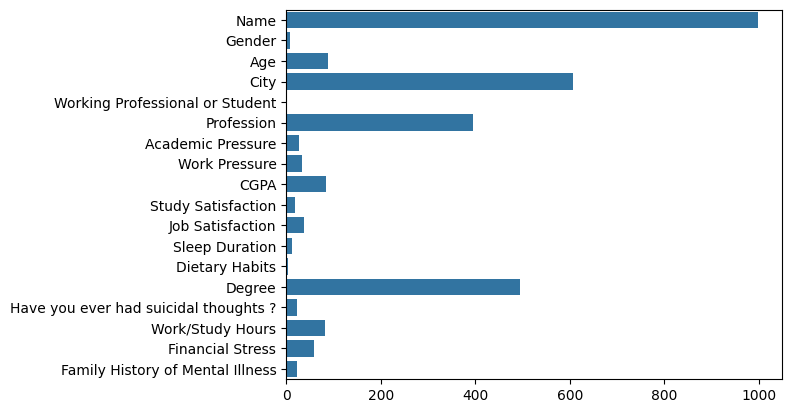

In [7]:
def get_diffs_with_lgb():
    from sklearn.model_selection import ShuffleSplit, cross_validate
    import lightgbm as lgb
    X_cat = df_var.loc[df_var.index.isin(X_all) & (df_var['dtype'] == 'Categorical')].index.tolist()
    X_cont = df_var.loc[df_var.index.isin(X_all) & (df_var['dtype'] == 'Float32')].index.tolist()
    X_lgb = X_cont + X_cat
    
    result = pd.concat([
        df_train[X_all].assign(
            is_train=True
        ),
        df_test[X_all].assign(
            **{i: dproc.rearrange_cat(df_test[i], df_train[i].dtype, lambda cats, val: -1) for i in X_cat}, # test에 train 없는 categories를 없애줍니다.
            is_train=False
        )
    ], axis=0).pipe(
        lambda x: cross_validate(
            lgb.LGBMClassifier(verbose=-1), x[X_all], x['is_train'], cv=ShuffleSplit(n_splits=1, train_size=0.6, random_state=123), 
            return_estimator=True, params={'categorical_feature':X_cat}, scoring='roc_auc'
        )
    )
    return result['estimator'][0].feature_importances_, result['test_score'][0]
feature_importance, roc_auc = sc.cache_result("train_test diff", get_diffs_with_lgb)
sns.barplot(x=feature_importance, y=X_all)
print(roc_auc)

In [8]:
X_cat = df_var.loc[df_var.index.isin(X_all) & (df_var['dtype'] == 'Categorical')].index.tolist()

In [9]:
sc.cache_result('Only_Test_Category',
    lambda : pd.concat([
        df_train[X_cat].apply(lambda x: set(x)).rename('train'),
        df_test[X_cat].apply(lambda x: set(x)).rename('test')
    ], axis=1).apply(
        lambda x: x['test'] - x['train'], axis=1
    )
)

City                                     {Ira, Aditi, Lawyer, Malyan, Ghopal, Less than...
Degree                                   {Bian, Rupak, Mechanical Engineer, B_Com, E.Ed...
Dietary Habits                           {MCA, Resistant, Raghav, 5 Healthy, Educationa...
Family History of Mental Illness                                                        {}
Gender                                                                                  {}
Have you ever had suicidal thoughts ?                                                   {}
Name                                     {Anwar, R. Bhavna, Mahan, Rakash, Rakav, Viya,...
Profession                               {No, M.Tech, Surgeon, MCA, Manvi, 3M, Name, M....
Sleep Duration                           {8-89 hours, 9-10 hours, 0, Vivan, 50-75 hours...
Working Professional or Student                                                         {}
dtype: object

In [10]:
df_city_freq = sc.cache_result('City_Freq',
    lambda : pd.concat([
        df_train['City'].value_counts().rename('train'),
        df_test['City'].value_counts().rename('test')
    ], axis=1)
)
df_city_freq.loc[df_city_freq.isna().any(axis=1)]

,train,test
City,,
Mihir,7.0,NaN
Nandini,4.0,NaN
Mahi,3.0,NaN
Harsha,3.0,NaN
Molkata,2.0,NaN
...,...,...
Avni,NaN,1.0
Mhopal,NaN,1.0
Less than 5 hours,NaN,1.0


City에는 노이즈가 존재합니다. 이들을 제거할 필요가 있다고 봅니다.


# Rearrange Categorical Variables

In [11]:
def get_city_proc():
    city_cat = pd.CategoricalDtype(['Noise'] + df_city_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 10]).index.tolist())
    return lambda x: dproc.rearrange_cat(x['City'], city_cat, lambda cats, x: x if x in cats else 0).fillna('Noise').rename('City_R')
city_proc = get_city_proc()

In [12]:
df_dietary_freq = sc.cache_result('Dietary Habits',
    lambda : pd.concat([
        df_train['Dietary Habits'].value_counts().rename('train'),
        df_test['Dietary Habits'].value_counts().rename('test')
    ], axis=1)
)
df_dietary_freq.loc[df_dietary_freq.isna().any(axis=1)]

,train,test
Dietary Habits,,
Yes,2.0,NaN
No Healthy,1.0,NaN
Class 12,1.0,NaN
Vegas,1.0,NaN
M.Tech,1.0,NaN
Electrician,1.0,NaN
Hormonal,1.0,NaN
Mihir,1.0,NaN
Less than Healthy,1.0,NaN


In [13]:
def get_dietary_proc():
    dietary_cat = pd.CategoricalDtype(['Noise'] + df_dietary_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 10]).index.tolist())
    to_healty = ['Yes', 'More Healthy', '5 Healthy']
    to_unhealty = ['No', 'No Healthy', 'Less Healthy', 'Less than Healthy', '5 Unhealthy']
    return lambda x: dproc.rearrange_cat(
            x['Dietary Habits'], dietary_cat, 
            lambda cats, x: x if x in cats else 2 if x in to_healty else 1 if x in to_unhealty else 0
        ).fillna('Noise').rename('Dietary Habits_R')
dietary_proc = get_dietary_proc()

In [14]:
df_prof_freq = sc.cache_result('Profession_Freq',
    lambda : pd.concat([
        df_train['Profession'].value_counts().rename('train'),
        df_test['Profession'].value_counts().rename('test')
    ], axis=1)
)
display(df_prof_freq.loc[df_prof_freq.isna().any(axis=1)])
def get_prof_proc():
    prof_cat = pd.CategoricalDtype(['Noise', 'Unknown'] + df_prof_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 10]).index.tolist())
    return lambda x: dproc.rearrange_cat(x['Profession'], prof_cat, lambda cats, x: x if x in cats else 0).fillna('Unknown').rename('Profession_R')
prof_proc = get_prof_proc()

,train,test
Profession,,
Academic,5.0,NaN
BCA,3.0,NaN
MBA,2.0,NaN
Dev,1.0,NaN
BE,1.0,NaN
Family Consultant,1.0,NaN
Visakhapatnam,1.0,NaN
Pranav,1.0,NaN
Moderate,1.0,NaN


In [15]:
df_sleep_freq = sc.cache_result('Sleep_Freq',
    lambda : pd.concat([
        df_train['Sleep Duration'].value_counts().rename('train'),
        df_test['Sleep Duration'].value_counts().rename('test')
    ], axis=1)
)
display(df_sleep_freq.loc[df_sleep_freq.isna().any(axis=1)])
def get_sleep_proc():
    dietary_cat = pd.CategoricalDtype(['Noise'] + df_sleep_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 20]).index.tolist())
    sleep_noise = df_sleep_freq.loc[df_sleep_freq.sum(axis=1) <= 20].index.to_series()
    s_hours = sleep_noise.str.findall('[0-9]+')
    repl_dict = pd.cut(s_hours.loc[s_hours.apply(lambda x: len(x) > 0)].apply(lambda x:[int(i) for i in x]).apply(
        lambda x: 8 if len(x) == 2 and x[0] > x[1] else np.mean(x)
    ), bins=[-np.inf, 5, 7, 8, 20, np.inf], labels= [1, 2, 3, 4, 0], right=False).astype(int).to_dict()
    return lambda x: dproc.rearrange_cat(
        x['Sleep Duration'], dietary_cat, 
        lambda cats, x: x if x in cats else repl_dict.get(x, 0)
    ).fillna('Noise').rename('Sleep Duration_R')
sleep_proc = get_sleep_proc()

,train,test
Sleep Duration,,
6-8 hours,4.0,NaN
No,4.0,NaN
10-11 hours,2.0,NaN
Sleep_Duration,2.0,NaN
45,2.0,NaN
45-48 hours,1.0,NaN
Work_Study_Hours,1.0,NaN
49 hours,1.0,NaN
Pune,1.0,NaN


In [16]:
df_degree_freq = sc.cache_result('Degree_Freq',
    lambda : pd.concat([
        df_train['Degree'].value_counts().rename('train'),
        df_test['Degree'].value_counts().rename('test')
    ], axis=1)
)
display(df_degree_freq.loc[df_degree_freq.isna().any(axis=1)])
def get_degree_proc():
    degree = {
        "BCom": "B.Com", "B.Com": "B.Com", "B.Comm": "B.Com",
        "B.Tech": "B.Tech", "BTech": "B.Tech", "B.T": "B.Tech",
        "BSc": "B.Sc", "B.Sc": "B.Sc", "Bachelor of Science": "B.Sc",
        "BArch": "B.Arch", "B.Arch": "B.Arch",
        "BA": "B.A", "B.A": "B.A",
        "BBA": "BBA", "BB": "BBA",
        "BCA": "BCA",
        "BE": "BE",
        "BEd": "B.Ed", "B.Ed": "B.Ed",
        "BPharm": "B.Pharm", "B.Pharm": "B.Pharm",
        "BHM": "BHM",
        "LLB": "LLB", "LL B": "LLB", "LL BA": "LLB", "LL.Com": "LLB", "LLCom": "LLB",
        "MCom": "M.Com", "M.Com": "M.Com",
        "M.Tech": "M.Tech", "MTech": "M.Tech", "M.T": "M.Tech",
        "MSc": "M.Sc", "M.Sc": "M.Sc", "Master of Science": "M.Sc",
        "MBA": "MBA",
        "MCA": "MCA",
        "MD": "MD",
        "ME": "ME",
        "MEd": "M.Ed", "M.Ed": "M.Ed",
        "MArch": "M.Arch", "M.Arch": "M.Arch",
        "MPharm": "M.Pharm", "M.Pharm": "M.Pharm",
        "MA": "MA", "M.A": "MA",
        "MPA": "MPA",
        "LLM": "LLM",
        "PhD": "PhD",
        "MBBS": "MBBS",
        "CA": "CA",
        "Class 12": "Class 12", "12th": "Class 12",
        "Class 11": "Class 11", "11th": "Class 11"
    }
    degree_cat = pd.CategoricalDtype(['Noise'] + df_degree_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 20]).index.tolist())
    return lambda x: dproc.rearrange_cat(x['Degree'].map(degree), degree_cat, lambda cats, x: x if x in cats else 0).fillna('Noise').rename('Degree_R')
degree_proc = get_degree_proc()

,train,test
Degree,,
UX/UI Designer,4.0,NaN
Kalyan,3.0,NaN
MEd,2.0,NaN
P.Com,2.0,NaN
Jhanvi,2.0,NaN
...,...,...
Pune,NaN,1.0
Bian,NaN,1.0
Kavya,NaN,1.0


In [17]:
df_train['Name'].value_counts().pipe(lambda x: x.loc[x > 20])

df_name_freq = sc.cache_result('Name_Freq',
    lambda : pd.concat([
        df_train['Name'].value_counts().rename('train'),
        df_test['Name'].value_counts().rename('test')
    ], axis=1)
)
display(df_name_freq.loc[df_name_freq.isna().any(axis=1)])
def get_name_proc():
    name_cat = pd.CategoricalDtype(['Noise'] + df_name_freq.sum(axis=1).pipe(lambda x: x.loc[x >= 20]).index.tolist())
    return lambda x: dproc.rearrange_cat(x['Name'], name_cat, lambda cats, x: x if x in cats else 0).fillna('Noise').rename('Name_R')
name_proc = get_name_proc()

,train,test
Name,,
Aarash,3.0,NaN
Tarsh,3.0,NaN
Shivvi,2.0,NaN
Prishti,2.0,NaN
Pradhya,2.0,NaN
...,...,...
Aarhar,NaN,1.0
AHM,NaN,1.0
Managan,NaN,1.0


In [18]:
# 카테고리 처리루틴을 종합하고 train에 적용합니다.
cat_procs_list = [
    (city_proc, 'City에서 train과 test에서 빈도가 10 미만은 Noise 처리합니다.'),
    (dietary_proc, 'Dietary Habits에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, 빈도가 10 미만은 Noise 처리합니다.'),
    (prof_proc, 'Profession에서 train과 test에서 빈도가 10 미만은 Noise 처리합니다.'),
    (sleep_proc, 'Sleep Duration에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, 빈도가 10 미만은 Noise 처리합니다.'),
    (degree_proc, 'Degree에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, 빈도가 10 미만은 Noise 처리합니다.'),
    (name_proc, 'Name에서 train과 test에서 빈도가 20 미만은 Noise 처리합니다.'),
]
df_train_cat_proc, df_cat_proc_var = sc.cache_result('train_cat_procs', lambda : dproc.apply_pd(df_train, cat_procs_list, 'cat_proc'))
df_train = dproc.join_and_assign(df_train, df_train_cat_proc)
df_var = pd.concat([df_var, df_cat_proc_var]).groupby(level=0).last()
del df_cat_proc_var
df_var.query('src == "cat_proc"')

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src,processor
City_R,NaN,NaN,0.0,140700.0,31.0,None,None,None,None,None,Categorical,City에서 train과 test에서 빈도가 10 미만은 Noise 처리합니다.,cat_proc,<function get_city_proc.<locals>.<lambda> at 0...
Degree_R,NaN,NaN,0.0,140700.0,28.0,None,None,None,None,None,Categorical,"Degree에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, ...",cat_proc,<function get_degree_proc.<locals>.<lambda> at...
Dietary Habits_R,NaN,NaN,0.0,140700.0,4.0,None,None,None,None,None,Categorical,Dietary Habits에서 train과 test에서 최대한 유사 빈도의 카테고리...,cat_proc,<function get_dietary_proc.<locals>.<lambda> a...
Name_R,NaN,NaN,0.0,140700.0,218.0,None,None,None,None,None,Categorical,Name에서 train과 test에서 빈도가 20 미만은 Noise 처리합니다.,cat_proc,<function get_name_proc.<locals>.<lambda> at 0...
Profession_R,NaN,NaN,0.0,140700.0,38.0,None,None,None,None,None,Categorical,Profession에서 train과 test에서 빈도가 10 미만은 Noise 처리...,cat_proc,<function get_prof_proc.<locals>.<lambda> at 0...
Sleep Duration_R,NaN,NaN,0.0,140700.0,5.0,None,None,None,None,None,Categorical,Sleep Duration에서 train과 test에서 최대한 유사 빈도의 카테고리...,cat_proc,<function get_sleep_proc.<locals>.<lambda> at ...


In [19]:
# 카테고리 처리루틴 후에 test에만 등장하는 카테고리가 있는지를 살펴봅니다.
display(
    sc.cache_result('Only_Test_Category_After_cat_procs',
        lambda : pd.concat([
            df_train_cat_proc.apply(lambda x: set(x)).rename('train'),
            dproc.apply_pd(df_test, cat_procs_list).apply(lambda x: set(x)).rename('test')
        ], axis=1).apply(
            lambda x: x['test'] - x['train'], axis=1
        )
    )
)
del df_train_cat_proc

City_R              {}
Dietary Habits_R    {}
Profession_R        {}
Sleep Duration_R    {}
Degree_R            {}
Name_R              {}
dtype: object

# Target Distribution

In [20]:
df_train[target].value_counts().pipe(lambda x: pd.concat([x, (x / x.sum()).rename('ratio')], axis=1))

,count,ratio
Depression,,
0,115133,0.818287
1,25567,0.181713


무조건 Depression이라고 예측을 해도 0.818 의 정확도를 얻을 수 있습니다.

# Categorical Variables

In [21]:
X_cat = df_var.query('src == "cat_proc"').index.to_list()
X_bool = df_var.query('n_unique == 2 and Description != "Target"').index.to_list()
np.array(X_cat), np.array(X_bool)
X_cat_all = X_cat + X_bool
X_cat_all

['City_R',
 'Degree_R',
 'Dietary Habits_R',
 'Name_R',
 'Profession_R',
 'Sleep Duration_R',
 'Family History of Mental Illness',
 'Gender',
 'Have you ever had suicidal thoughts ?',
 'Working Professional or Student']

## Chi2 Independent Test with target

In [22]:
from scipy.stats import chi2_contingency
df_chi2_result = sc.cache_result('Chi2_test_result',
    lambda : df_train[X_cat_all].apply(lambda x: chi2_contingency(pd.crosstab(x, df_train[target]))).apply(lambda x: pd.Series([x[0], x[1]], index=['stat', 'pvalue']))
).T.sort_values('stat', ascending=False)
df_chi2_result

,stat,pvalue
Profession_R,42058.339673,0.000000e+00
Working Professional or Student,38157.585828,0.000000e+00
Have you ever had suicidal thoughts ?,17142.055358,0.000000e+00
Degree_R,13063.034997,0.000000e+00
Name_R,4498.648616,0.000000e+00
Dietary Habits_R,3243.557753,0.000000e+00
Sleep Duration_R,1195.719459,1.349409e-257
City_R,1055.176825,1.134086e-202
Family History of Mental Illness,38.227325,6.296449e-10
Gender,9.289548,2.304650e-03


In [23]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(5, random_state=123, shuffle=True)

In [24]:
from sklearn.metrics import roc_auc_score, accuracy_score
X = ['Have you ever had suicidal thoughts ?', 'Profession_R', 'Age_2']
for train_idx, test_idx in skf.split(df_train, df_train[target]):
    df_cv_train, df_valid = df_train.iloc[train_idx], df_train.iloc[test_idx]
    s_mean = (df_cv_train.assign(Age_2=lambda x: x['Age'] <= 33).groupby(X, observed=True)[target].mean() > 0.5).astype('int')
    print(
        accuracy_score(df_valid[target], df_valid.assign(Age_2=lambda x: x['Age'] <= 33)[X].apply(tuple,axis=1).map(s_mean).fillna(df_cv_train[target].mode()[0]))
    )

0.9070362473347549
0.9111229566453447
0.9120824449182658
0.912864250177683
0.910270078180526


## Mode/Accuracy

In [25]:
# 그룹별 최빈값으로 예측했을 때의 정확도를 구합니다.
def mode_accuracy():
    s_acc_list = list()
    for i in X_cat_all:
        s_target_mode = df_train.groupby(i, observed=True)[target].apply(lambda x: x.mode()[0])
        s_acc_list.append(accuracy_score(df_train[target], df_train[i].map(s_target_mode)))
    return pd.Series(s_acc_list, index=X_cat_all, name='mode/accuracy')
s_mode_accuracy = sc.cache_result('Mode Accuracy', mode_accuracy)
s_mode_accuracy

City_R                                   0.818287
Degree_R                                 0.820910
Dietary Habits_R                         0.818287
Name_R                                   0.818287
Profession_R                             0.836482
Sleep Duration_R                         0.818287
Family History of Mental Illness         0.818287
Gender                                   0.818287
Have you ever had suicidal thoughts ?    0.818287
Working Professional or Student          0.852196
Name: mode/accuracy, dtype: float64

## Chi2 Independent Test between features

In [26]:
from scipy.spatial.distance import pdist, squareform
chi2_tab = sc.cache_result('Chi2_test_with_features',
    lambda : pdist(df_train[X_cat_all].T, lambda u, v: chi2_contingency(pd.crosstab(u, v))[0])
)
pd.DataFrame(squareform(chi2_tab), index=X_cat_all, columns = X_cat_all)

,City_R,Degree_R,Dietary Habits_R,Name_R,Profession_R,Sleep Duration_R,Family History of Mental Illness,Gender,Have you ever had suicidal thoughts ?,Working Professional or Student
City_R,0.000000,13282.602096,1058.396887,100433.962350,11030.335783,532.831952,217.077020,1314.771425,168.585714,1865.532343
Degree_R,13282.602096,0.000000,1357.855499,82150.671941,581573.375189,513.033711,66.033101,862.428119,1218.514459,6632.736693
Dietary Habits_R,1058.396887,1357.855499,0.000000,4433.494132,1575.356771,86.938022,4.318453,210.096721,615.498831,397.128570
Name_R,100433.962350,82150.671941,4433.494132,0.000000,91764.840894,3378.816317,946.086905,138020.297942,1198.880599,7203.710985
Profession_R,11030.335783,581573.375189,1575.356771,91764.840894,0.000000,652.189054,95.958660,1050.729087,3310.598264,98560.119999
Sleep Duration_R,532.831952,513.033711,86.938022,3378.816317,652.189054,0.000000,4.028703,11.074140,189.903973,107.506921
Family History of Mental Illness,217.077020,66.033101,4.318453,946.086905,95.958660,4.028703,0.000000,33.736193,12.103271,23.967716
Gender,1314.771425,862.428119,210.096721,138020.297942,1050.729087,11.074140,33.736193,0.000000,16.562594,6.202542
Have you ever had suicidal thoughts ?,168.585714,1218.514459,615.498831,1198.880599,3310.598264,189.903973,12.103271,16.562594,0.000000,2666.502431
Working Professional or Student,1865.532343,6632.736693,397.128570,7203.710985,98560.119999,107.506921,23.967716,6.202542,2666.502431,0.000000


In [27]:
# Profession과 Working Professional or Student과 빈도수를 구해봅니다.
sc.cache_result('Conti_Professional_R',
    lambda : df_train.groupby('Working Professional or Student', observed=False)['Profession_R'].apply(lambda x: x.value_counts()).unstack()
)

,Noise,Unknown,Teacher,Content Writer,Architect,Consultant,HR Manager,Pharmacist,Doctor,Business Analyst,...,Civil Engineer,UX/UI Designer,Digital Marketer,Accountant,Finanancial Analyst,Mechanical Engineer,Graphic Designer,Research Analyst,Investment Banker,Student
Working Professional or Student,,,,,,,,,,,,,,,,,,,,,
Working Professional,43,8763,24900,7812,4362,4229,4022,3891,3253,3161,...,1469,1451,1369,1339,1329,1177,1163,690,393,4
Student,0,27867,6,2,8,0,0,2,2,0,...,1,1,3,0,0,0,0,0,0,3


Profession과 Working Professional or Student 에는 일관성이 없는 데이터들이 약간씩 존재합니다. 

In [28]:
pd.crosstab(
    index=df_train[['Working Professional or Student', 'Have you ever had suicidal thoughts ?']].sum(axis=1), 
    columns=df_train[target]
)

Depression,0,1
row_0,,
StudentNo,7866,2379
StudentYes,3699,13957
Working ProfessionalNo,59814,1079
Working ProfessionalYes,43754,8152


In [29]:
pd.crosstab(
    index=df_train[['Working Professional or Student', 'Have you ever had suicidal thoughts ?']].sum(axis=1), 
    columns=df_train[target], normalize='index'
)

Depression,0,1
row_0,,
StudentNo,0.767789,0.232211
StudentYes,0.209504,0.790496
Working ProfessionalNo,0.982280,0.017720
Working ProfessionalYes,0.842947,0.157053


# Numerical Variables

In [30]:
X_cont = df_var.loc[(df_var['Description'] != 'Target') & (df_var['dtype'] == 'Float32')].index.to_list()
df_var.loc[X_cont]

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src,processor
Academic Pressure,1.00,5.0,187836.0,46664.0,6.0,True,True,True,True,Float32,Float32,None,org,None
Age,18.00,60.0,0.0,234500.0,43.5,True,True,True,True,Float32,Float32,None,org,None
CGPA,5.03,10.0,187836.0,46664.0,329.5,True,True,True,True,Float32,Float32,None,org,None
Financial Stress,1.00,5.0,4.0,234496.0,5.5,True,True,True,True,Float32,Float32,None,org,None
Job Satisfaction,1.00,5.0,46684.0,187816.0,6.0,True,True,True,True,Float32,Float32,None,org,None
Study Satisfaction,1.00,5.0,187836.0,46664.0,6.0,True,True,True,True,Float32,Float32,None,org,None
Work Pressure,1.00,5.0,46696.0,187804.0,6.0,True,True,True,True,Float32,Float32,None,org,None
Work/Study Hours,0.00,12.0,0.0,234500.0,13.0,True,True,True,True,Float32,Float32,None,org,None


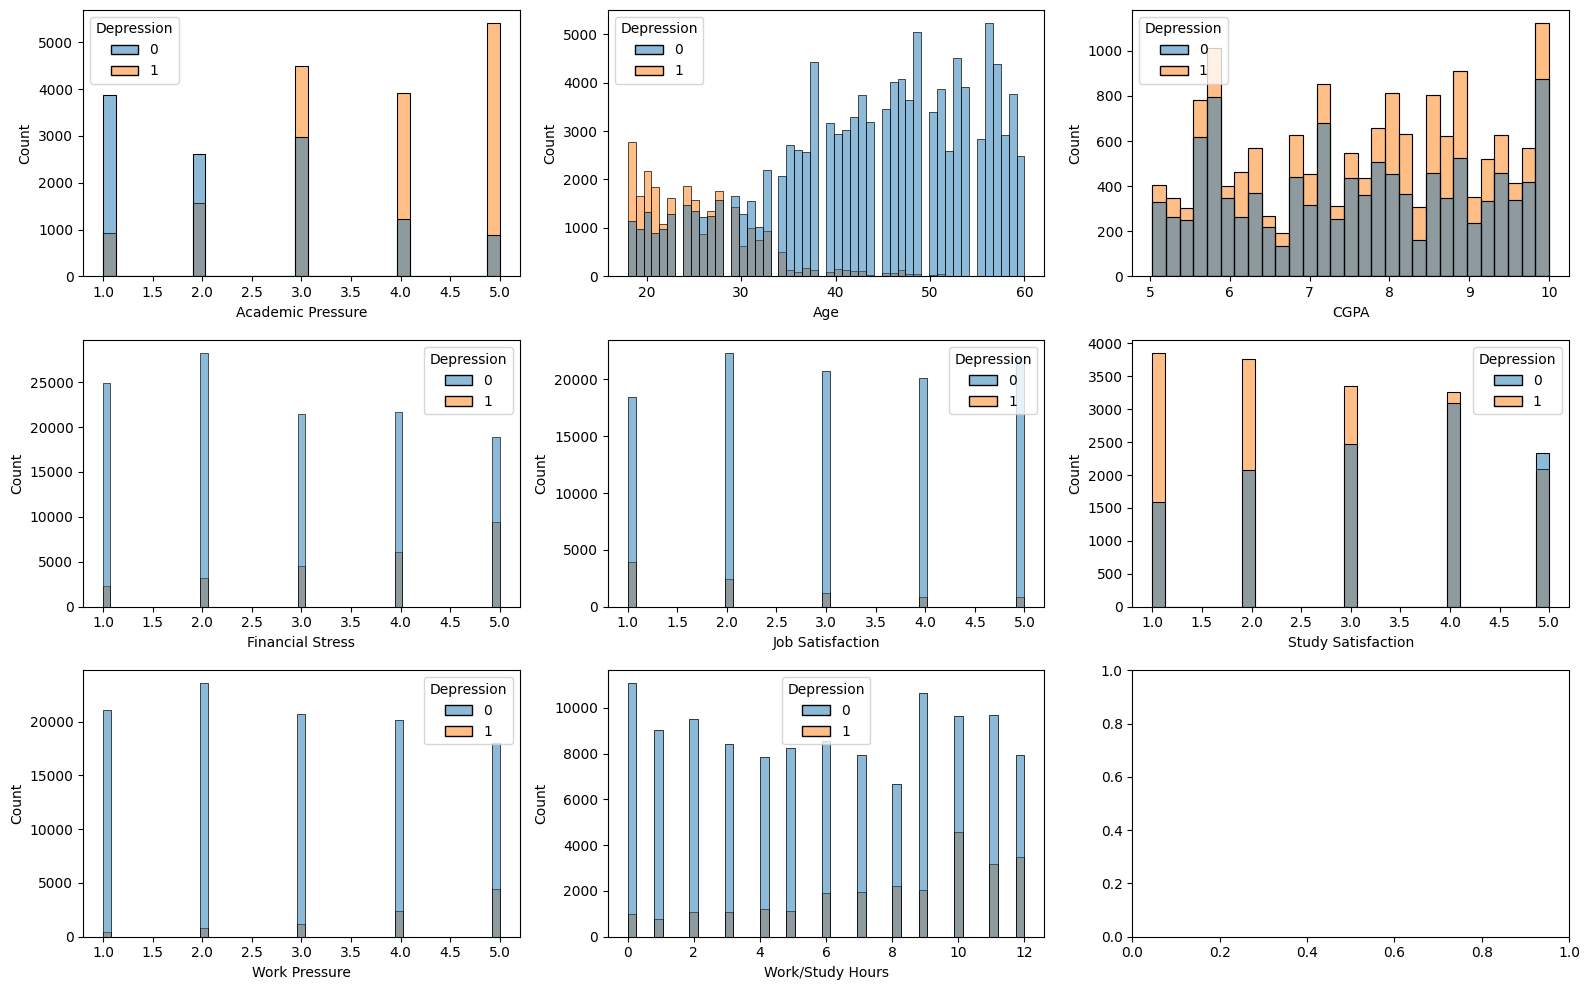

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_train, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

In [32]:
# CGPA가 가장 상관성이 없어 보입니다. mannwhitnry U 검증을 해봅니다.
from scipy.stats import mannwhitneyu
mannwhitneyu(df_train.loc[df_train[target] == 0, 'CGPA'].dropna(), df_train.loc[df_train[target] == 1, 'CGPA'].dropna())

MannwhitneyuResult(statistic=92054552.5, pvalue=0.00032127284999336757)

In [33]:
df_train[X_cont].corr()

,Academic Pressure,Age,CGPA,Financial Stress,Job Satisfaction,Study Satisfaction,Work Pressure,Work/Study Hours
Academic Pressure,1.000000,-0.075956,-0.025195,0.152105,-1.000000,-0.112228,NaN,0.095650
Age,-0.075956,1.000000,0.005129,-0.083589,0.030793,0.008862,-0.098924,-0.118356
CGPA,-0.025195,0.005129,1.000000,0.006398,1.000000,-0.047078,NaN,0.002875
Financial Stress,0.152105,-0.083589,0.006398,1.000000,-0.029160,-0.065001,0.024412,0.036134
Job Satisfaction,-1.000000,0.030793,1.000000,-0.029160,1.000000,-1.000000,-0.036958,-0.029227
Study Satisfaction,-0.112228,0.008862,-0.047078,-0.065001,-1.000000,1.000000,NaN,-0.036934
Work Pressure,NaN,-0.098924,NaN,0.024412,-0.036958,NaN,1.000000,-0.002808
Work/Study Hours,0.095650,-0.118356,0.002875,0.036134,-0.029227,-0.036934,-0.002808,1.000000


In [34]:
def inconsitency_stat():
    return (
        pd.concat([
            df_train['Working Professional or Student'],
            df_train['Academic Pressure'].isna()
        ], axis=1).value_counts(),
        df_train[['Academic Pressure', 'CGPA', 'Study Satisfaction']].isna().sum(axis=1).value_counts(),
        df_train[['Job Satisfaction', 'Work Pressure']].isna().sum(axis=1).value_counts()
    )
s_ws_ac_freq, s_acs_frwq, s_jw = sc.cache_result('inconsitency_stat', inconsitency_stat)
display(s_ws_ac_freq)
display(s_acs_frwq)
display(s_jw)

Working Professional or Student  Academic Pressure
Working Professional             True                 112794
Student                          False                 27892
                                 True                      9
Working Professional             False                     5
Name: count, dtype: int64

3    112799
0     27892
1         7
2         2
Name: count, dtype: int64

0    112777
2     27905
1        18
Name: count, dtype: int64

Working Professional or Student와 Academic Pressure 는 배타적인 성질을 지닌듯 보입니다. 

'Academic Pressure', 'CGPA', 'Study Satisfaction' 와 'Job Satisfaction', 'Work Pressure'의 값의 유무도 배타적으로 보이고 변수의 이름상으로도 배타성이 있습니다.

'Academic Pressure', 'CGPA', 'Study Satisfaction' 의 결측 유무 또한 All or Nothing 으로 보이는데, 간혹 불일치가 있습니다.

'Job Satisfaction', 'Work Pressure'의 결측 유무 또한 All or Nothing 으로 보이는데, 간혹 불일치가 있습니다.

## 일관성이 없는 경우 조사

In [35]:
df_train.groupby('Working Professional or Student', observed=True)[['Academic Pressure', 'CGPA', 'Study Satisfaction', 'Work Pressure', 'Job Satisfaction']].apply(
    lambda x: x.notna().sum()
)

,Academic Pressure,CGPA,Study Satisfaction,Work Pressure,Job Satisfaction
Working Professional or Student,,,,,
Working Professional,5,6,6,112779,112782
Student,27892,27892,27891,3,8


In [36]:
# Working Professional or Student 별로 구분해보면, Wokring Professional인데 Academic Pressure, CPGA, Study Satisfaction에 값이 있거나,
# Student 인데 Work Pressure, Job Satisfaction에 값이 있습니다.
# 이 변수들끼리는 서로 배타적인 성질에 반하는데요, 이를 보정하고,
# 여기서 Student이면 Profession_R에도 Student으로 만듭니다.
from sklearn.naive_bayes import MultinomialNB
def get_ws_correct_proc():
    clf_nb = MultinomialNB()
    clf_nb.fit(
        df_train[['Academic Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work Pressure']].isna(), df_train['Working Professional or Student']
    )
    def correct_proc(x):
        s_is_student = pd.Series(
            clf_nb.predict(x[['Academic Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work Pressure']].isna()) == 'Student', 
            index = x.index, name='is_student'
        )
        s_prop_r2 = x['Profession_R'].where(~s_is_student, 'Student').rename('Profession_R2').pipe(lambda x: x.where(s_is_student | (x != 'Student'), 'Unknown'))
        return pd.concat([s_is_student, s_prop_r2], axis=1)
    return correct_proc
ws_correct_proc = get_ws_correct_proc()

In [37]:
ws_correct_proc(df_train)

,is_student,Profession_R2
id,,
0,False,Chef
1,False,Teacher
2,True,Student
3,False,Teacher
4,False,Business Analyst
...,...,...
140695,False,Unknown
140696,False,Content Writer
140697,False,Marketing Manager


In [38]:
inconsi_procs = [
    (ws_correct_proc, {
        'is_student': "Working Professional or Student에서 Academic Pressure, CGPA, Study Satisfaction, Job Satisfaction, Work Pressure의 결측치와 모순된점을 바로 잡은값",
        'Profession_R2': "is_student를 Profession_R에 반영하여 교정한 값"
    }),
]
df_inconsi, df_inconsi_var = sc.cache_result('inconsi_proc1', lambda : dproc.apply_pd(df_train, inconsi_procs, 'inconsi'))
df_train = dproc.join_and_assign(df_train, df_inconsi)
df_var = pd.concat([df_var, df_inconsi_var], axis=0).groupby(level=0).last()
del df_inconsi, df_inconsi_var

## Fillna

In [45]:
def get_fillna_proc(df_train):
    df_student = df_train.loc[df_train['is_student'], ['Academic Pressure', 'CGPA', 'Study Satisfaction']]
    df_worker = df_train.loc[~df_train['is_student'], ['Work Pressure', 'Job Satisfaction']]
    s_academic = df_student.groupby('Academic Pressure')['Study Satisfaction'].agg(lambda x: x.mode()[0])
    s_study = df_student.groupby('Study Satisfaction')['Academic Pressure'].agg(lambda x: x.mode()[0])
    s_cgpa = df_student.groupby(['Academic Pressure', 'Study Satisfaction'])['CGPA'].mean()
    s_wp = df_worker.groupby('Work Pressure')['Job Satisfaction'].agg(lambda x: x.mode()[0])
    s_js = df_worker.groupby('Job Satisfaction')['Work Pressure'].agg(lambda x: x.mode()[0])
    academic_mode = df_student['Academic Pressure'].mode()[0]
    study_mode = df_student['Study Satisfaction'].mode()[0]
    cgpa_mean = df_student['CGPA'].mean()
    wp_mode = df_worker['Work Pressure'].mode()[0]
    js_mode = df_worker['Job Satisfaction'].mode()[0]
    fs_mode = df_train['Financial Stress'].mode()[0]
    def num_proc(x):
        df_tmp = x[['Academic Pressure', 'CGPA', 'Study Satisfaction']].where(x['is_student'], [0, 0, 0])
        df_tmp['Academic Pressure'] = df_tmp['Academic Pressure'].fillna(df_tmp['Study Satisfaction'].map(s_study)).fillna(academic_mode).astype('int8')
        df_tmp['Study Satisfaction'] = df_tmp['Study Satisfaction'].fillna(df_tmp['Study Satisfaction'].map(s_study)).fillna(study_mode).astype('int8')
        df_tmp['CGPA'] = df_tmp['CGPA'].fillna(df_tmp[['Academic Pressure', 'Study Satisfaction']].apply(lambda x: tuple(x), axis=1).map(s_study)).fillna(study_mode)
        df_tmp2 = x[['Work Pressure', 'Job Satisfaction']].where(~x['is_student'], [0, 0])
        df_tmp2['Work Pressure'] = df_tmp2['Work Pressure'].fillna(df_tmp2['Job Satisfaction'].map(s_js)).fillna(wp_mode).astype('int8')
        df_tmp2['Job Satisfaction'] = df_tmp2['Job Satisfaction'].fillna(df_tmp2['Work Pressure'].map(s_wp)).fillna(js_mode).astype('int8')
        return pd.concat([df_tmp, df_tmp2, x['Financial Stress'].fillna(fs_mode).astype('int8')], axis=1).rename(columns=lambda x: x + '_FN')
    return num_proc

In [46]:
fillna_proc = [
    (get_fillna_proc(df_train),  {
            i + '_FN': '{}의 결측을 처리한 변수입니다.'
            for i in ['Academic Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work Pressure', 'Financial Stress']
        }
    )
]
df_fillna, df_fillna_var = sc.cache_result('fillna_proc', lambda : dproc.apply_pd(df_train, fillna_proc, 'fillna'))
df_train = dproc.join_and_assign(df_train, df_fillna)
df_var = pd.concat([df_var, df_fillna_var]).groupby(level=0).last()
df_var

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src,processor
Academic Pressure,1.0,5.0,187836.0,46664.0,6.0,True,True,True,True,Float32,Float32,None,org,None
Academic Pressure_FN,0.0,5.0,0.0,140700.0,6.0,True,True,True,True,None,Int8,{}의 결측을 처리한 변수입니다.,fillna,<function get_fillna_proc.<locals>.num_proc at...
Age,18.0,60.0,0.0,234500.0,43.5,True,True,True,True,Float32,Float32,None,org,None
CGPA,5.03,10.0,187836.0,46664.0,329.5,True,True,True,True,Float32,Float32,None,org,None
CGPA_FN,0.0,10.0,0.0,140700.0,333.0,True,True,True,True,None,Float64,{}의 결측을 처리한 변수입니다.,fillna,<function get_fillna_proc.<locals>.num_proc at...
City,None,None,0.0,234500.0,83.0,True,True,True,True,Categorical,Categorical,None,org,None
City_R,None,None,0.0,140700.0,31.0,None,None,None,None,None,Categorical,City에서 train과 test에서 빈도가 10 미만은 Noise 처리합니다.,cat_proc,<function get_city_proc.<locals>.<lambda> at 0...
Degree,None,None,4.0,234496.0,102.0,True,True,True,True,Categorical,Categorical,None,org,None
Degree_R,None,None,0.0,140700.0,28.0,None,None,None,None,None,Categorical,"Degree에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, ...",cat_proc,<function get_degree_proc.<locals>.<lambda> at...
Depression,0.0,1.0,0.0,140700.0,2.0,True,True,True,True,Int8,Int8,Target,org,None


## Kruskal Test

In [48]:
from scipy.stats import kruskal

X_cat = [
    'City_R', 'Degree_R', 'Dietary Habits_R', 'Name_R', 'Profession_R', 'Sleep Duration_R',
    'Family History of Mental Illness', 'Gender', 'Have you ever had suicidal thoughts ?', 'Working Professional or Student'
]
result = sc.cache_result(
    'kruskal', 
    lambda : df_train[['Academic Pressure', 'CGPA','Financial Stress', 'Job Satisfaction', 'Study Satisfaction', 'Work Pressure', 'Age', 'Work/Study Hours']].apply(
        lambda x: pd.Series([kruskal(*x.groupby(df_train[i], observed=True).agg(lambda x: x.dropna().tolist() ))[0] for i in X_cat], index=X_cat) , axis = 0
    )
)
result

,Academic Pressure,CGPA,Financial Stress,Job Satisfaction,Study Satisfaction,Work Pressure,Age,Work/Study Hours
City_R,203.688798,290.994181,219.735846,189.877510,112.507119,115.659703,1791.443417,237.256941
Degree_R,241.345148,166.730536,451.840822,166.320089,160.144650,864.274595,21870.504128,526.613743
Dietary Habits_R,232.445339,0.288739,357.766437,91.127993,18.193555,87.427217,752.583606,133.132763
Name_R,442.928937,769.012539,831.408459,820.277822,470.851085,888.252921,7092.189078,866.941080
Profession_R,NaN,NaN,695.938076,359.667031,NaN,955.435611,55686.935323,2080.207329
Sleep Duration_R,61.149494,14.060807,12.310234,30.877497,10.748947,78.619647,557.475494,82.118837
Family History of Mental Illness,24.698151,0.481726,2.137260,18.173285,0.464813,6.027281,12.079138,19.479157
Gender,13.850568,36.155370,8.998682,7.293955,6.960415,0.150928,5.363696,6.892421
Have you ever had suicidal thoughts ?,1880.676551,1.911745,1079.810704,349.844140,194.814228,265.370836,2429.932936,587.308626
Working Professional or Student,0.154970,0.225162,391.655760,1.421908,0.148269,1.501902,44884.720807,1917.321714


# Feature Analysis

In [49]:
from sklearn.metrics import roc_auc_score
for i in range(20, 41):
    print(i, roc_auc_score(df_train[target], df_train.groupby(df_train['Age'] <= i)[target].transform('mean')))

20 0.6147200822970631
21 0.6468106582441663
22 0.6638408243162452
23 0.6899157016463304
24 0.7201089154405009
25 0.7451170946023241
26 0.7568504206354035
27 0.777933974928408
28 0.8056198959745695
29 0.826417877345042
30 0.8328841815340718
31 0.8456658675098488
32 0.856077403100004
33 0.864834609450988
34 0.8657557882848992
35 0.8563878924055968
36 0.8469914222140966
37 0.8390572052457748
38 0.8224391511352607
39 0.8103521618713317
40 0.8006438127518443


In [50]:
age2_proc = lambda x: (x['Age'] <= 34).rename('Age_2')
df_train['Age_2'] = age2_proc(df_train)

In [51]:
pd.concat([
    df_train.groupby('Profession_R2', observed=True)[target].mean().rename('prob'),
    df_train['Profession_R2'].value_counts().rename('count')
], axis=1).sort_values('prob', ascending=False)

,prob,count
Profession_R2,,
Student,0.585535,27901
Unknown,0.374886,8768
Graphic Designer,0.185727,1163
Judge,0.108645,1712
HR Manager,0.106912,4022
Mechanical Engineer,0.101105,1177
Architect,0.097662,4362
Noise,0.093023,43
Financial Analyst,0.083227,1574


In [52]:
df_train.groupby(df_train['Profession_R2'] == 'Unknown')['Age'].mean()

Profession_R2
False    41.086483
True     29.887888
Name: Age, dtype: float32

In [53]:
X_lgb_cat = df_var.drop(index=target).query('src == "cat_proc"').index.tolist()
X_lgb_num_fn = df_var.drop(index=target).query('src == "fillna"').index.tolist()
X_lgb_num_na = df_var.drop(index=target).query('dtype == "Float32" and na > 0').index.tolist()
X_lgb_num = ['Age', 'Work/Study Hours']
X_lgb_bool = df_var.drop(index=target).query('src == "org" and n_unique == 2').index.to_list()
X_lgb_inconsi = df_var.drop(index=target).query('src == "inconsi" and dtype != "Categorical"').index.tolist()
X_lgb_cat, X_lgb_num_fn, X_lgb_num_na, X_lgb_num, X_lgb_bool, X_lgb_inconsi

(['City_R',
  'Degree_R',
  'Dietary Habits_R',
  'Name_R',
  'Profession_R',
  'Sleep Duration_R'],
 ['Academic Pressure_FN',
  'CGPA_FN',
  'Financial Stress_FN',
  'Job Satisfaction_FN',
  'Study Satisfaction_FN',
  'Work Pressure_FN'],
 ['Academic Pressure',
  'CGPA',
  'Financial Stress',
  'Job Satisfaction',
  'Study Satisfaction',
  'Work Pressure'],
 ['Age', 'Work/Study Hours'],
 ['Family History of Mental Illness',
  'Gender',
  'Have you ever had suicidal thoughts ?',
  'Working Professional or Student'],
 ['is_student'])

# Simple Estimators

## Decision Tree

3 Depth Decision Tree로 살펴서 어떤 속성이 target을 예측하기 위한 키요소가 되는지 분석해봅니다.

In [54]:
hparams = {
    'model_params': {'max_depth': 3, 'criterion': 'entropy'},
    'X_num':  ['Academic Pressure_FN', 'CGPA_FN', 'Financial Stress_FN', 'Job Satisfaction_FN', 'Study Satisfaction_FN', 'Work Pressure_FN', 'Age', 'Work/Study Hours'],
    'X_ohe': ['City_R', 'Degree_R', 'Dietary Habits_R', 'Name_R', 'Profession_R2', 'Sleep Duration_R', 'Gender', 'Family History of Mental Illness', 'Have you ever had suicidal thoughts ?', 'Working Professional or Student'],
    'ohe': {'drop': 'if_binary'}
}

result = sc.cache_result('simple_dt', lambda : sgml.cv(df_train, skf, hparams, config, dt_adapter, result_proc=sgml.m_learning_result))

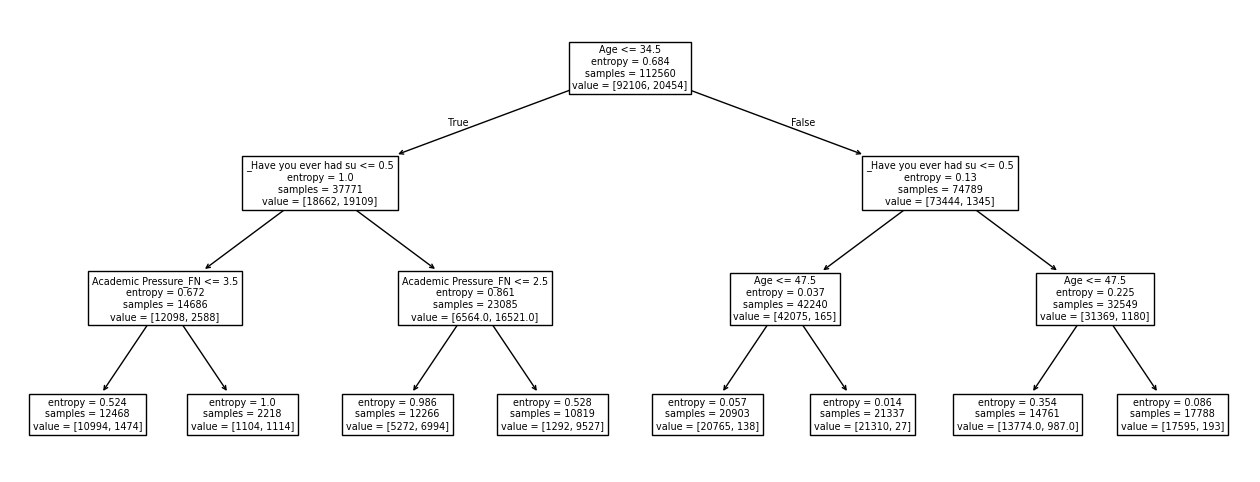

[0.903091684434968, 0.9063965884861407, 0.9074271499644634, 0.907818052594172, 0.9042999289267946]


In [55]:
from sklearn.tree import plot_tree
plt.figure(figsize=(16, 6))
plot_tree(result['model_result'][0]['model'], feature_names=[i[4: 25] for i in result['model_result'][0]['variables']])
plt.show()
print(result['valid_scores'])

Age와 Have you ever had suicidal ... ? 이 주요소이고, Academic Pressure 권에 잡혔습니다.

##  Logistic Regression

In [58]:
hparams = {
    'model_params': {},
    'X_mm':  ['Age', 'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work/Study Hours'],
    'X_ohe': ['Have you ever had suicidal thoughts ?'],
    'ohe': {'drop': 'first'}
}

result = sc.cache_result(
    'simple_lr',
    lambda : sgml.cv(df_train, skf, hparams, config, lr_adapter, result_proc=sgml.m_learning_result)
)
np.mean(result['valid_scores']) , result['model_result'][0]['model'].coef_

(0.9353375977256574,
 array([[-7.07040709,  4.48301241,  2.18858643,  2.97580157, -1.1724222 ,
         -2.70377209,  1.57223509,  2.47490759]]))

In [61]:
df_train['proba'] = result['valid_prd']
(
    df_train.query('proba < 0.25 or proba > 0.75').pipe(
        lambda x: x[target] != (x['proba'] > 0.5)
    ).mean(),
    df_train.query('proba > 0.25 and proba < 0.75').pipe(
        lambda x: x[target] == (x['proba'] > 0.5)
    ).mean()
)

(0.03280118848303346, 0.6346168113361526)

In [62]:
df_confusing = df_train.query('proba > 0.25 and proba < 0.75')
df_confusing[target].value_counts(normalize=True)

Depression
1    0.500631
0    0.499369
Name: proportion, dtype: float64

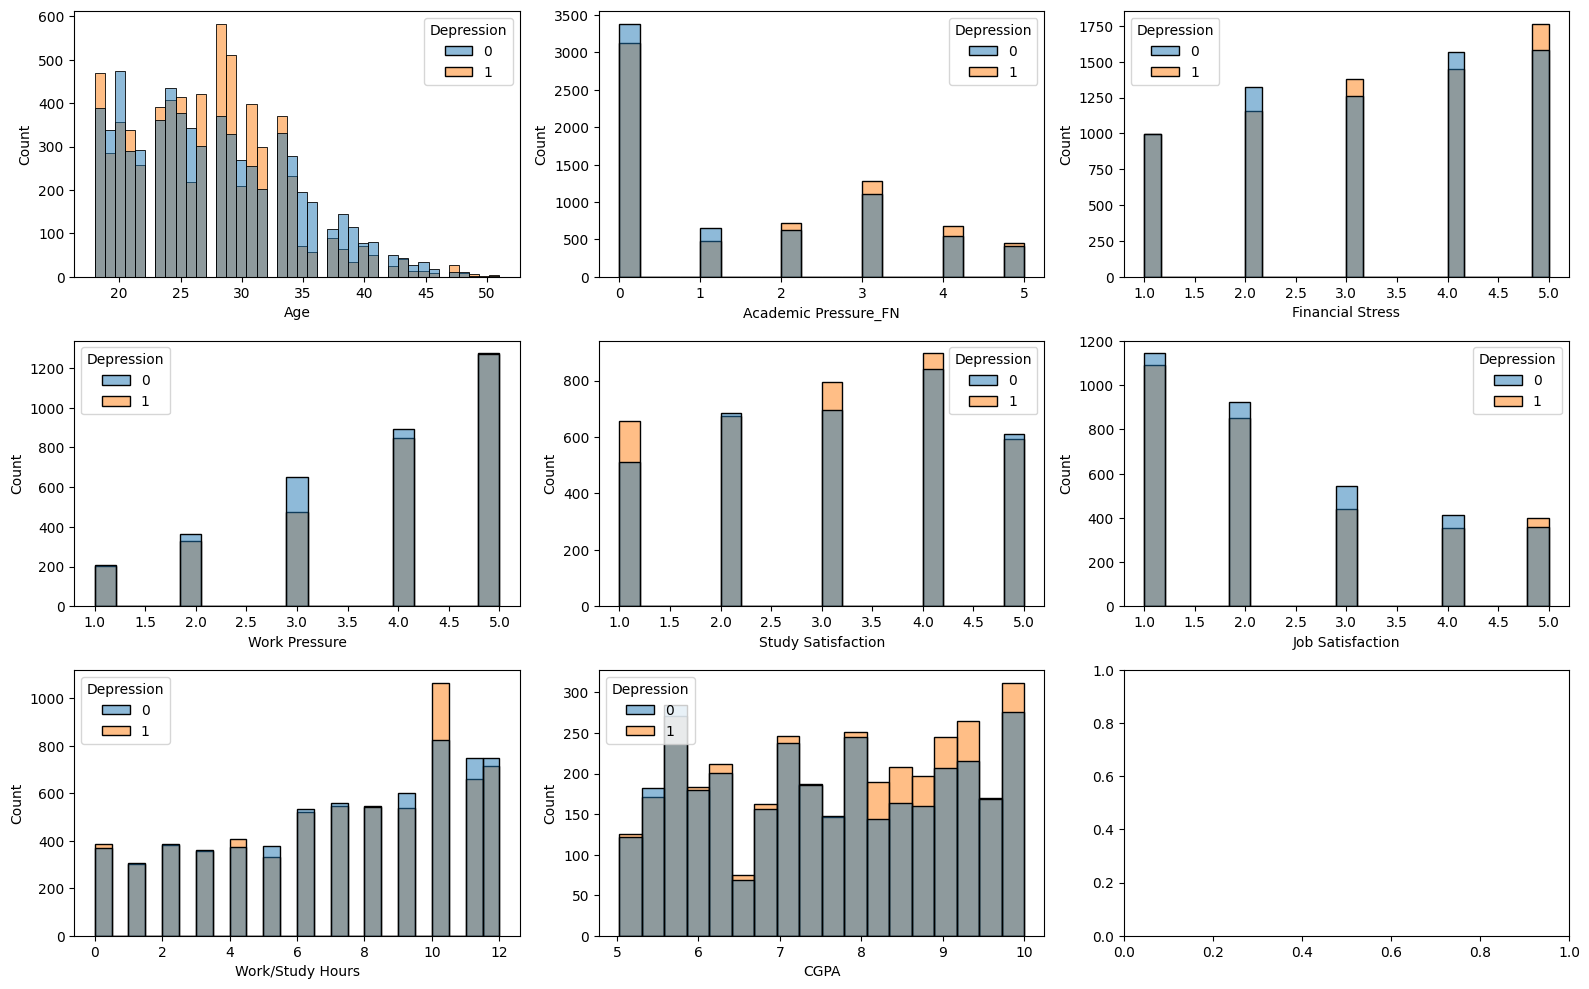

In [63]:
X_cont = ['Age', 'Academic Pressure_FN', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'CGPA']
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_confusing, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

Work/Study Hours가 10인 경우 유난히 Peak에 있습니다.

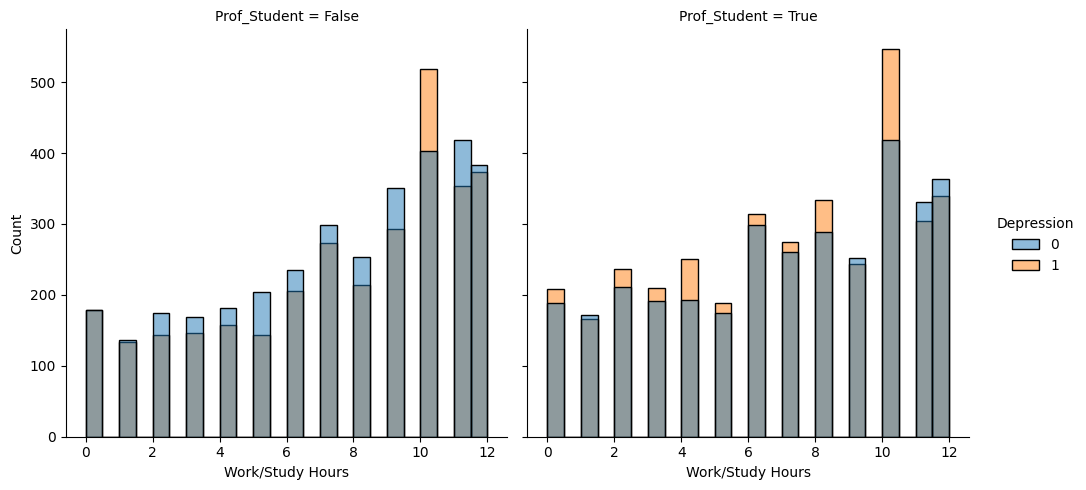

In [64]:
sns.displot(df_confusing.assign(Prof_Student=lambda x: x['Profession_R2'] == 'Student'), x='Work/Study Hours', col='Prof_Student', hue=target)
plt.show()

Work/Study Hours 에서, Work가 주는 의미와 Study가 Depression에 주는 의미가 각각 다르다고 봅니다.

이를 Work Hours와 Study Hours로 나누어 선형 회귀 모델로 만들어 볼 만합니다.

In [65]:
hours_proc = lambda x: pd.concat([
                (x['Work/Study Hours'] * (~x['is_student']) ).astype('int').rename('Work Hours'),
                (x['Work/Study Hours'] * x['is_student']).astype('int').rename('Study Hours'),
                (x['Work/Study Hours'] == 10).rename('WS_10')
], axis=1)

df_train[['Work Hours', 'Study Hours', 'WS_10']]  = hours_proc(df_train)

In [66]:
hparams = {
    'model_params': {},
    'X_mm':  ['Age', 'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 'Study Hours', 'CGPA_FN'],
    'X_ohe': ['Have you ever had suicidal thoughts ?', 'WS_10'],
    'ohe': {'drop': 'first'}
}

result = sc.cache_result(
    'simple_lr2',
    lambda : sgml.cv(df_train, skf, hparams, config, lr_adapter, result_proc=sgml.m_learning_result), 1
)
np.mean(result['valid_scores'])

0.9355579246624023

/home/sun9sun9/python312/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/sun9sun9/python312/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


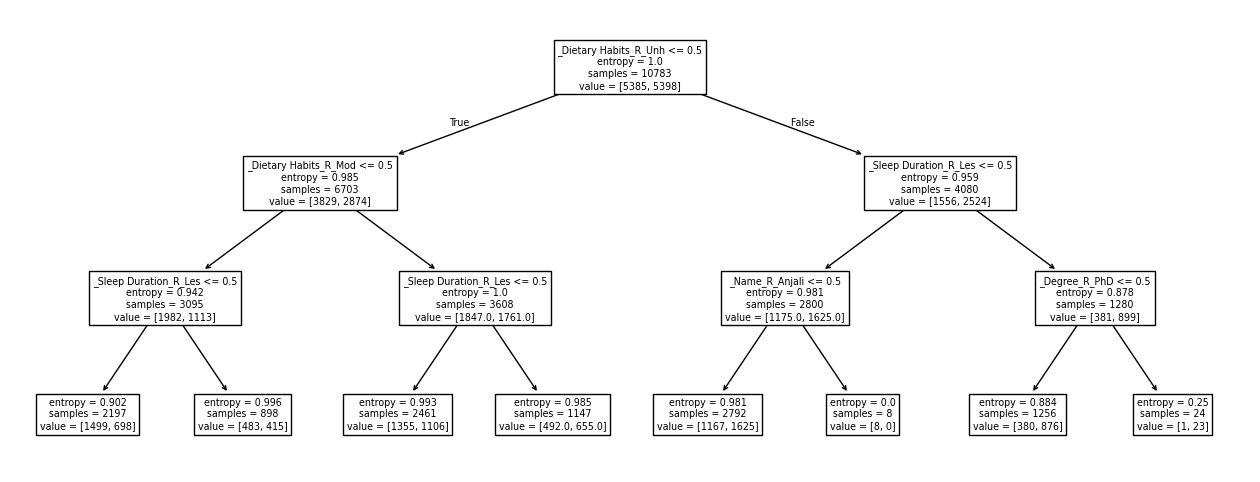

[0.6097922848664689, 0.5953264094955489, 0.5971810089020771, 0.5953264094955489, 0.6003710575139146]


In [67]:
hparams = {
    'model_params': {'max_depth': 3, 'criterion': 'entropy'},
    'X_ohe': ['City_R', 'Degree_R', 'Dietary Habits_R', 'Name_R', 'Sleep Duration_R', 'Gender', 'Family History of Mental Illness'],
    'ohe': {'drop': 'if_binary', 'handle_unknown': 'ignore'}
}

result = sc.cache_result('confusing_dt', lambda : sgml.cv(df_confusing, skf, hparams, config, dt_adapter, result_proc=sgml.m_learning_result), 1)
from sklearn.tree import plot_tree
plt.figure(figsize=(16, 6))
plot_tree(result['model_result'][0]['model'], feature_names=[i[4: 25] for i in result['model_result'][0]['variables']])
plt.show()
print(result['valid_scores'])

In [68]:
ord_proc =lambda x: pd.concat([
    x['Dietary Habits_R'].map({'Moderate': 0, 'Unhealthy': -1, 'Healthy': 1}).fillna(0).astype('int').rename('Dietary_level'),
    x['Sleep Duration_R'].map({'Less than 5 hours': -2, '5-6 hours': -1, '7-8 hours': 1, 'More than 8 hours': 2}).fillna(0).astype('int').rename('Sleep_level')
], axis=1)
df_train[['Dietary_level', 'Sleep_level']] = ord_proc(df_train)

In [69]:
hparams = {
    'model_params': {},
    'X_mm':  [
        'Age', 'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 
        'Study Hours', 'CGPA_FN', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness'],
    'ohe': {'drop': 'first'}
}

result = sc.cache_result(
    'simple_lr3',
    lambda : sgml.cv(df_train, skf, hparams, config, lr_adapter, result_proc=sgml.m_learning_result)
)
np.mean(result['valid_scores'])

0.934271499644634

In [73]:
hparams = {
    'model_params': {},
    'X_mm':  [
        'Age', 'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 
        'Study Hours', 'CGPA_FN', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Name_R', 'Profession_R2', 'Age_2'],
    'ohe': {'drop': 'first', 'min_frequency': 50}
}

result = sc.cache_result(
    'simple_lr4',
    lambda : sgml.cv(df_train, skf, hparams, config, lr_adapter, result_proc=sgml.m_learning_result)
)
np.mean(result['valid_scores']), np.mean(result['train_scores'])

(0.9393105899076047, 0.9405277185501065)

In [74]:
pd.Series(result['model_result'][0]['model'].coef_[0], index=result['model_result'][0]['variables']).abs().sort_values(ascending=False).iloc[:30]

mm__Age                                           5.319659
mm__Academic Pressure_FN                          4.238375
mm__Work Pressure_FN                              3.127512
mm__Job Satisfaction_FN                           2.704076
ohe__Have you ever had suicidal thoughts ?_Yes    2.468027
mm__Financial Stress_FN                           2.214760
mm__Work Hours                                    1.675651
ohe__Name_R_Saurav                                1.378081
mm__Study Hours                                   1.270422
mm__Study Satisfaction_FN                         1.190055
ohe__Name_R_Ishan                                 1.143376
ohe__Profession_R2_Chemist                        1.140250
ohe__Age_2_True                                   1.090432
mm__Dietary_level                                 1.053727
ohe__Name_R_Ishita                                1.018910
ohe__Name_R_Pari                                  0.998205
ohe__Profession_R2_Entrepreneur                   0.9951

In [75]:
df_train['proba'] = result['valid_prd']
df_confusing = df_train.query('proba > 0.25 and proba < 0.75')
df_confusing[target].value_counts(normalize=True)

Depression
0    0.501132
1    0.498868
Name: proportion, dtype: float64

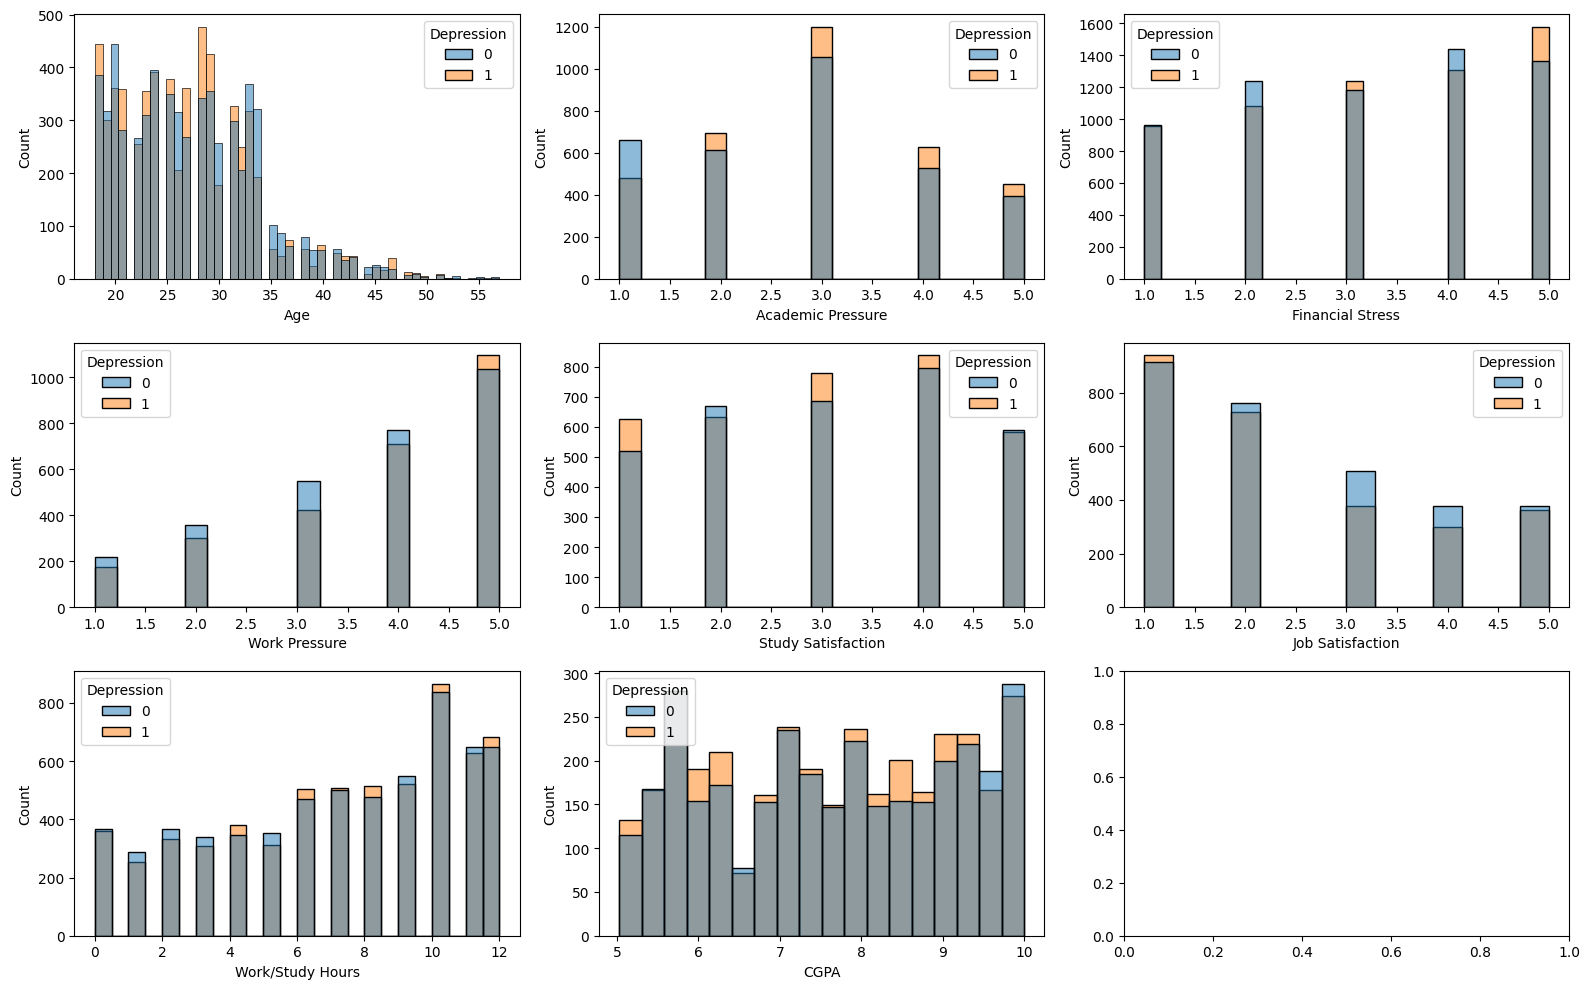

In [76]:
X_cont = ['Age', 'Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'CGPA']
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_confusing, x=i, hue=target, ax=ax)
plt.tight_layout()
plt.show()

In [77]:
# Logistic Regression으로 부터 도출한 파생 변수를 정리합니다.
lr_proc = [
    (hours_proc, 
    {
        'Work Hours': 'Work/Study Hours에서 Working Professional에 해당하는 경우만을 값을 유지하고 나머지는 0으로 설정한 변수입니다.', 
        'Study Hours': 'Work/Study Hours에서 Student에 해당하는 경우만을 값을 유지하고 나머지는 0으로 설정한 변수입니다.', 
        'WS_10': 'Working/Study Hours에 10시간에 해당하는 경우 Depression에 Peak이 있어 이를 10시간 여부를 나타내는 변수입니다',
        'Age_2': '34를 기준으로 이하, 초과 여부를 나타내는 변수입니다.'
    }),
    (ord_proc,
     {'Dietary_level': 'Dietary Habits_R을 서수화한 변수입니다.',
      'Sleep_level': 'Sleep Duration_R을 서수화한 변수입니다.'}),
    (age2_proc, 'Age를 34 이전 여부를 나타내는 변수입니다.'),
]


df_lr, df_lr_var = dproc.apply_pd(df_train, lr_proc, 'fillna')
df_train = dproc.join_and_assign(df_train, df_lr)
df_var = pd.concat([df_var, df_lr_var]).groupby(level=0).last()

# LGBM

In [78]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.02, 'num_leaves': 15, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 
        'Study Hours', 'CGPA_FN', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    'validation_fraction': 0.1
}

result = sc.cache_result(
    'simple_lgb',
    lambda : sgml.cv(df_train, skf, hparams, config, lgb_adapter)
)
np.mean(result['valid_scores']), np.mean(result['train_scores'])

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

(0.9401847903340441, 0.9463610518834399)

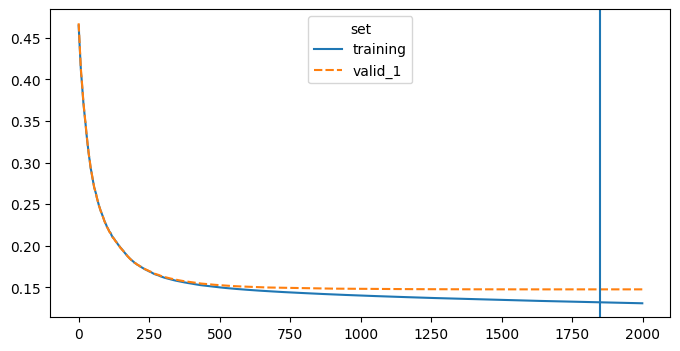

In [79]:
plt.figure(figsize=(8, 4))
valid_result = pd.concat([i['valid_result'] for i in result['model_result']], axis=1).T.groupby(level=1).mean().T
sns.lineplot(valid_result)
plt.axvline(valid_result['valid_1'].idxmin())
plt.show()

## SHAP Analysis

In [80]:
import shap
shap.initjs()

In [81]:
c, X = sc.cache_result(
    'LGBM_shap',
    lambda : sgml.train(df_train, hparams, config, lgb_adapter, result_proc = sgml.m_learning_result)
)

In [205]:
explainer = sc.cache_result(
    'lgb_shap_explainer', lambda : shap.TreeExplainer(c['model'])
)

In [206]:
def get_shap_values():
    ct = c['preprocessor']
    df_sub = df_train.sample(frac=0.05, random_state=123)
    X = pd.DataFrame(ct.transform(df_sub).todense(), index=df_sub.index, columns=c['variables'])
    shap_values = explainer.shap_values(X)
    return shap_values, df_sub, X

shap_values, df_sub, X = sc.cache_result(
    'lgb_shap_values', get_shap_values
)

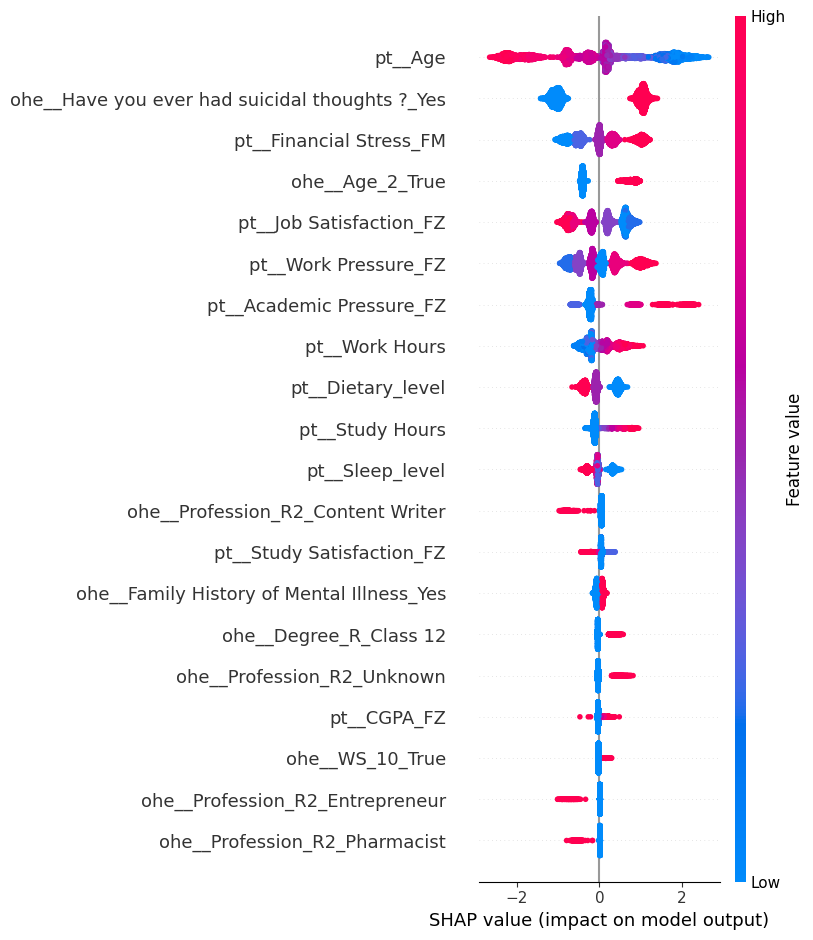

In [207]:
shap.summary_plot(shap_values, X)

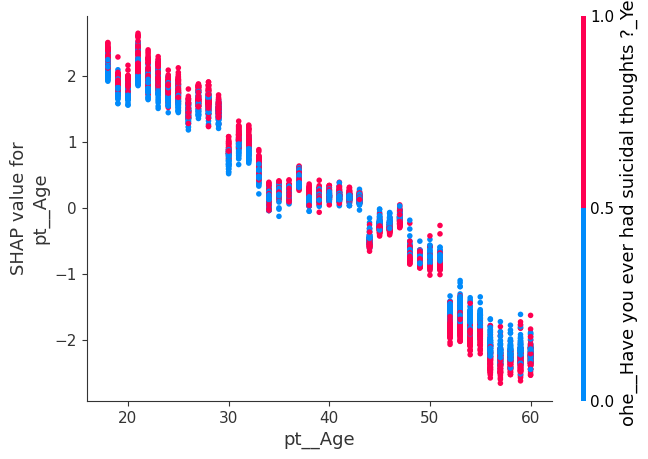

In [208]:
shap.dependence_plot('pt__Age', shap_values, X)

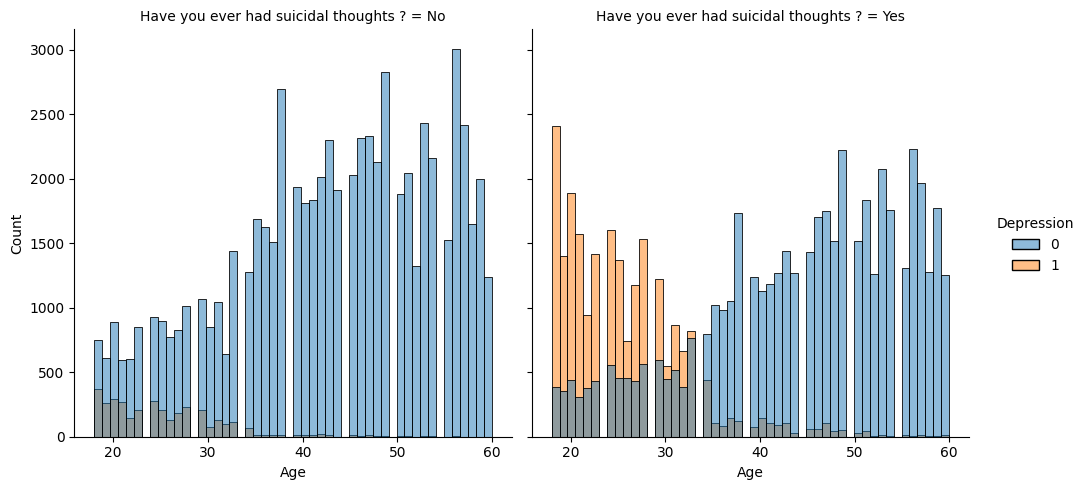

In [209]:
sns.displot(df_train, x='Age', col='Have you ever had suicidal thoughts ?', hue=target, height=5)

Have you ever had suicidal thoughts ? 은 Age가 작을 수록 Depression에 주는 영향이 큽니다.

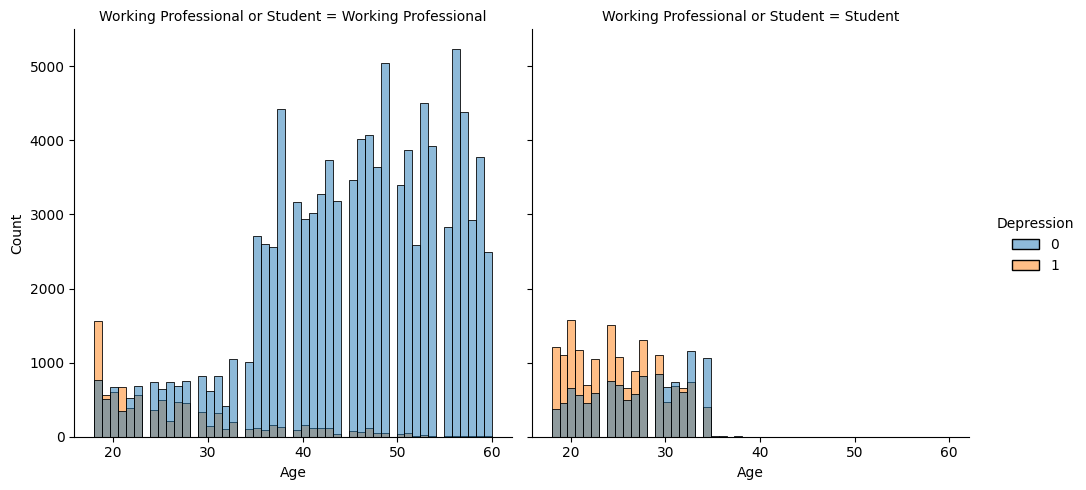

In [210]:
sns.displot(df_train, x='Age', col='Working Professional or Student', hue=target, height=5)

Age가 36 이하에 학생이 집중되어 있습니다. 

Age 18세 이면서 Working Professional 일 경우에 Peak이 있습니다.

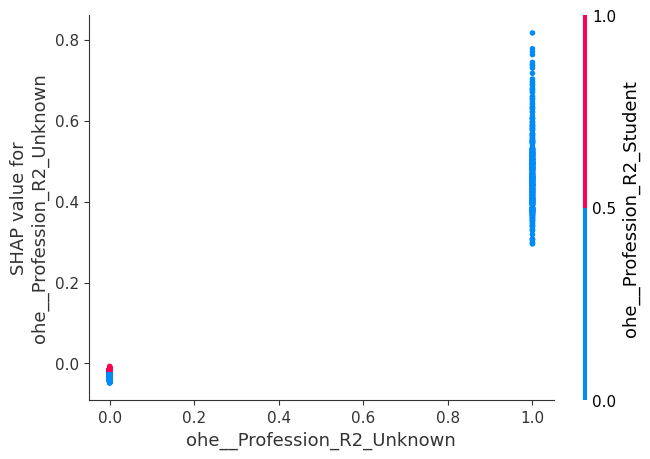

In [211]:
shap.dependence_plot('ohe__Profession_R2_Unknown', shap_values, X)

## Profession_R2 & Degree_R

In [108]:
df_train.groupby('Profession_R2', observed=True)[target].mean().sort_values(ascending=False).iloc[:5]

Profession_R2
Student             0.585535
Unknown             0.374886
Graphic Designer    0.185727
Judge               0.108645
HR Manager          0.106912
Name: Depression, dtype: float64

In [109]:
df_train.groupby('Degree_R', observed=True)[target].agg(['mean', 'count']).sort_values('mean', ascending=False).iloc[:10]

,mean,count
Degree_R,,
Class 12,0.512526,14729
Noise,0.232759,116
B.Tech,0.214011,4425
BCA,0.203868,5739
BE,0.190077,3104
MA,0.175268,2887
MSc,0.174011,4879
BHM,0.172590,4305
MBBS,0.170019,3082


In [110]:
df_train.query("Profession_R2 == 'Student'").groupby('Degree_R', observed=True)[target].agg(['mean', 'count']).iloc[:10]

,mean,count
Degree_R,,
Noise,0.600000,35
Class 12,0.708080,6077
B.Ed,0.546816,1869
B.Arch,0.589310,1478
B.Com,0.566401,1506
B.Pharm,0.528395,810
BCA,0.571528,1433
M.Ed,0.505481,821
MCA,0.535441,1044


In [111]:
df_train.query("Profession_R2 != 'Student' and Profession_R2 != 'Unknown'").groupby('Degree_R', observed=True)[target].agg(['mean', 'count']).iloc[:10]

,mean,count
Degree_R,,
Noise,0.041096,73
Class 12,0.440678,59
B.Ed,0.048614,9812
B.Arch,0.069094,7251
B.Com,0.061818,6600
B.Pharm,0.052767,5041
BCA,0.080773,4296
M.Ed,0.027881,4842
MCA,0.049498,4182


In [112]:
df_train.query("Profession_R2 == 'Unknown'").groupby('Degree_R', observed=False)[target].agg(['mean', 'count']).iloc[:10]

,mean,count
Degree_R,,
Noise,0.375000,8
Class 12,0.374724,8593
B.Ed,0.600000,10
B.Arch,0.384615,13
B.Com,0.285714,7
B.Pharm,0.800000,5
BCA,0.400000,10
M.Ed,0.200000,5
MCA,0.250000,8


In [113]:
pd.crosstab(
    index=dproc.combine_cat(df_train[['Profession_R2', 'Degree_R']], '_'),
    columns=df_train[target], margins='columns'
).assign(
    prob_1 = lambda x: x[1] / x['All']
).sort_index().iloc[:50]

Depression,0,1,All,prob_1
row_0,,,,
Accountant_B.Com,1053,79,1132,0.069788
Accountant_BBA,2,0,2,0.000000
Accountant_BCA,1,0,1,0.000000
Accountant_M.Com,194,6,200,0.030000
Accountant_MBA,0,1,1,1.000000
Accountant_ME,1,0,1,0.000000
Accountant_MSc,1,0,1,0.000000
Accountant_PhD,1,0,1,0.000000
All,115133,25567,140700,0.181713


In [83]:
combine_Age_Suicidal = lambda x: dproc.combine_cat(x[['Age_2', 'Have you ever had suicidal thoughts ?']].assign(Age_2= lambda x: x['Age_2'].astype('category')), '_').rename('Age_Suicidal')
combine_WS_Degree_proc = lambda x: dproc.combine_cat(x[['Working Professional or Student', 'Degree_R']], '_').rename('WS_Degree')
combine_Prof_Degree_proc = lambda x: dproc.combine_cat(x[['Profession_R2', 'Degree_R']], '_').rename('Prof_Degree')
is_Age_18_Unknown = lambda x: ((x['Age'] == 18) & (x['Profession_R2'] == 'Unknown')).rename('Age_18_Unknown')
combine_cat_procs = [
    (combine_Age_Suicidal, "Age 2와 Have you ever had suicidal thoughts ?을 결합합니다."),
    (combine_WS_Degree_proc, "Working Professional or Student와 Degree_R을 결합합니다."),
    (combine_Prof_Degree_proc, "Profession_R2과 Degree_R을 결합합니다."), 
    (is_Age_18_Unknown, "18세 이고 직업이 Unknown 인지 여부를 나타냅니다."), 
]

df_combine_cat, df_combine_cat_procs_var = sc.cache_result('combine_cat_procs', lambda : dproc.apply_pd(df_train, combine_cat_procs, 'combine_cat'), 1)
df_train = dproc.join_and_assign(df_train, df_combine_cat)
df_var = pd.concat([df_var, df_combine_cat_procs_var], axis=0).groupby(level=0).last()
#del df_combine_cat, df_combine_cat_procs_var
df_var.query('src == "combine_cat"')

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src,processor
Age_18_Unknown,False,True,0.0,140700.0,2.0,True,True,True,True,None,Bool,18세 이고 직업이 Unknown 인지 여부를 나타냅니다.,combine_cat,<function <lambda> at 0x7f8f1d279b20>
Age_Suicidal,None,None,0.0,140700.0,4.0,None,None,None,None,None,Categorical,Age 2와 Have you ever had suicidal thoughts ?을 ...,combine_cat,<function <lambda> at 0x7f8f1d279800>
Prof_Degree,None,None,0.0,140700.0,602.0,None,None,None,None,None,Categorical,Profession_R2과 Degree_R을 결합합니다.,combine_cat,<function <lambda> at 0x7f8f1d279d00>
WS_Degree,None,None,0.0,140700.0,56.0,None,None,None,None,None,Categorical,Working Professional or Student와 Degree_R을 결합합니다.,combine_cat,<function <lambda> at 0x7f8f1d279a80>


In [84]:
hparams = {
    'model_params': {},
    'X_tgt': ['Prof_Degree', 'Age_Suicidal'],
    'X_mm':  [
        'Age', 'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 
        'Study Hours', 'CGPA_FN', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Name_R', 'Profession_R2', 'Age_2'],
    #'X_num': ['Age_18_Unknown'], 효과가 없습니다.
    'ohe': {'drop': 'first', 'min_frequency': 50}
}

result = sc.cache_result(
    'simple_lr4',
    lambda : sgml.cv(df_train, skf, hparams, config, lr_adapter, result_proc=sgml.m_learning_result),
)
np.mean(result['valid_scores']), np.mean(result['train_scores'])

(0.9393105899076047, 0.9405277185501065)

# XGB

In [85]:
hparams = {
    'model_params': {'n_estimators': 1500, 'learning_rate': 0.03, 'max_depth': 5, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_tgt': ['Prof_Degree', 'Age_Suicidal'],
    'X_num':  [
        'Age', 'Academic Pressure_FN', 'Financial Stress_FN', 'Work Pressure_FN', 'Study Satisfaction_FN', 'Job Satisfaction_FN', 'Work Hours', 
        'Study Hours', 'CGPA_FN', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50},
    'validation_fraction': 0.1
}

result = sc.cache_result(
    'simple_xgb',
    lambda : sgml.cv(df_train, skf, hparams, config, xgb_adapter, device='cuda')
)
np.mean(result['valid_scores'])

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

/home/sun9sun9/python312/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:55:15] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

0.9396943852167732

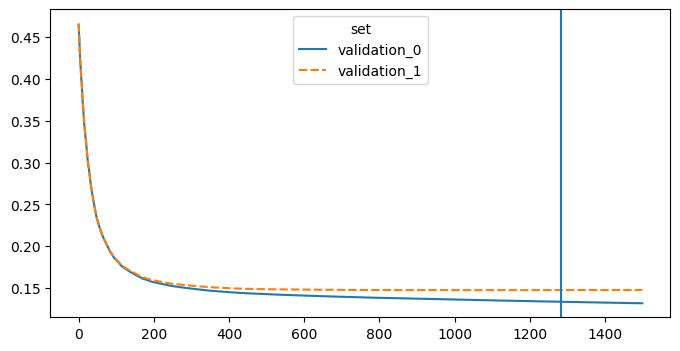

In [86]:
plt.figure(figsize=(8, 4))
valid_result = pd.concat([i['valid_result'] for i in result['model_result']], axis=1).T.groupby(level=1).mean().T
sns.lineplot(valid_result)
plt.axvline(valid_result['validation_1'].idxmin())
plt.show()

In [87]:
result = sc.cache_result(
    'simple_xgb_model',
    lambda : sgml.train(df_train, hparams, config, xgb_adapter)
)

In [88]:
def get_shap_interaction_values():
    ct = result[0]['preprocessor']
    df_sub = df_train.sample(frac=0.01, random_state=123)
    X = pd.DataFrame(ct.transform(df_sub).todense(), index=df_sub.index, columns=result[0]['variables'])
    shap_values = shap.TreeExplainer(result[0]['model']).shap_interaction_values(X)
    return shap_values, df_sub, X

shap_interaction_values, df_sub, X = sc.cache_result(
    'xgb_shap_interaction_values', get_shap_interaction_values
)

## SHAP Interaction Analysis

Interaction Analysis는 XGB 만 가능하여 XGB를 만들어 따로 수행

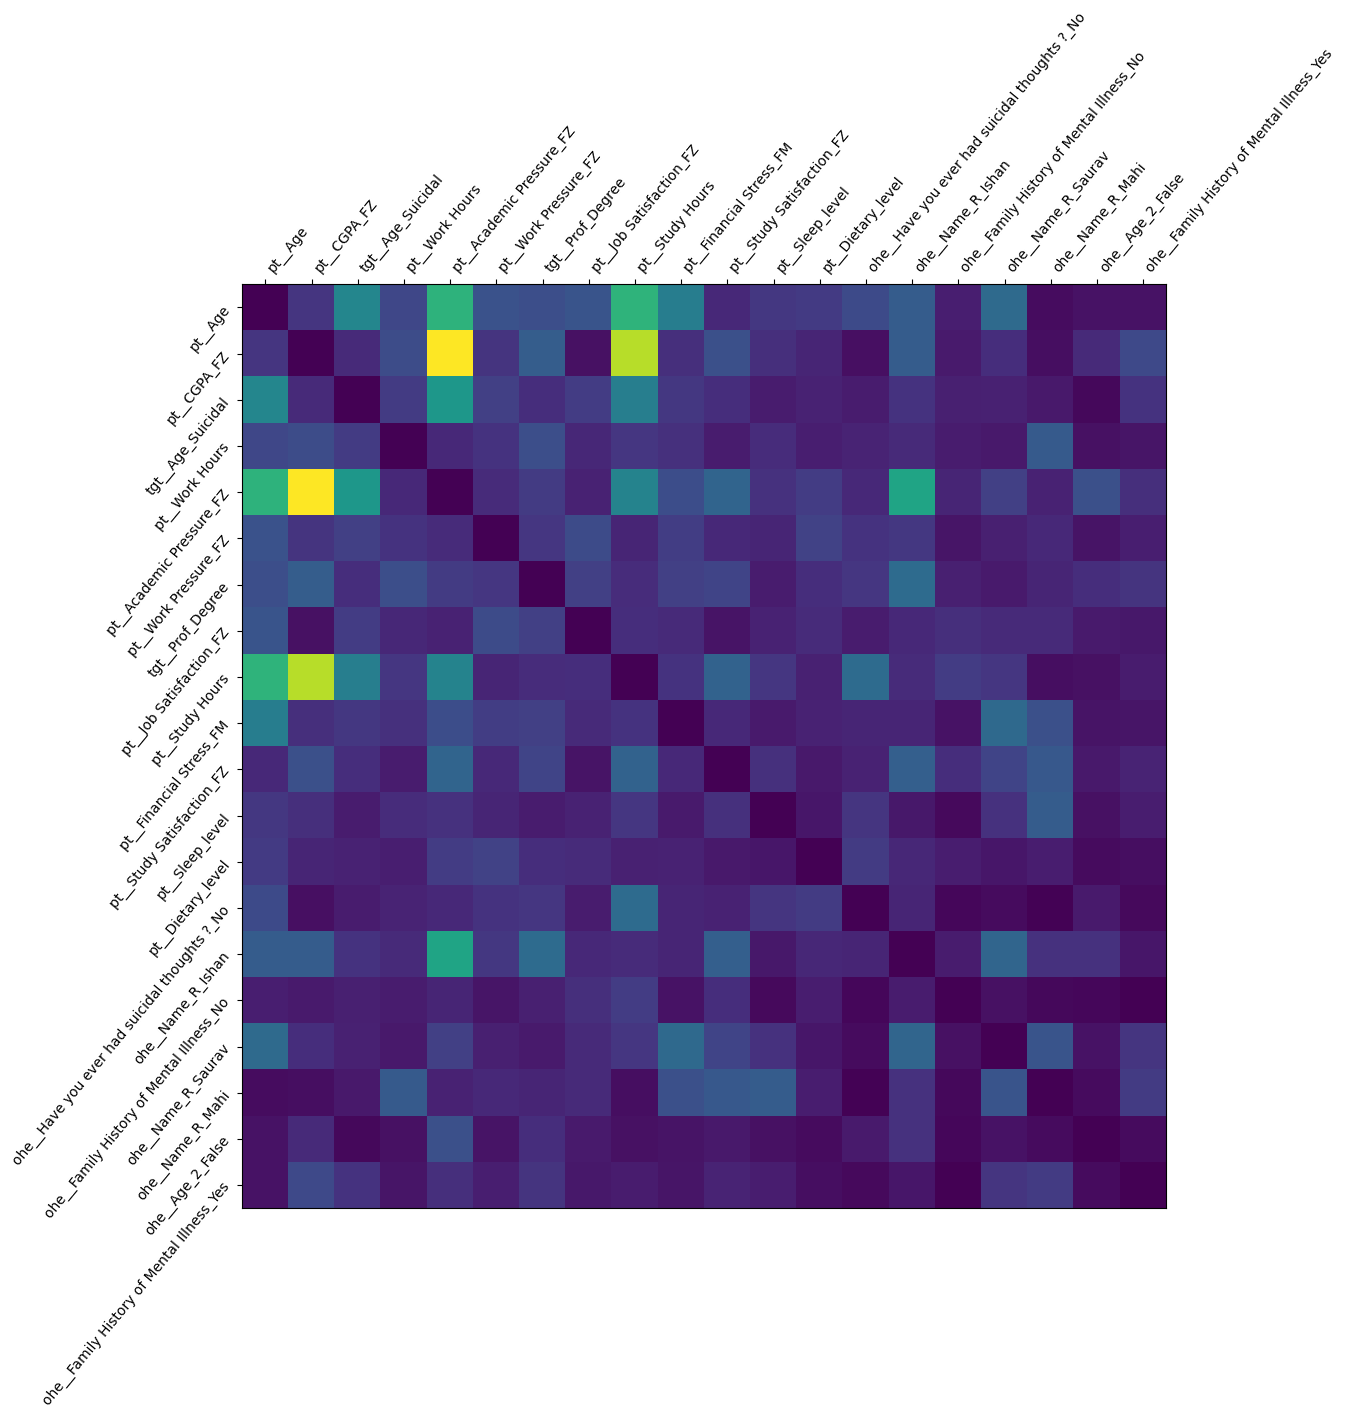

In [224]:
interaction_matrix = np.abs(shap_interaction_values).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(12, 12))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

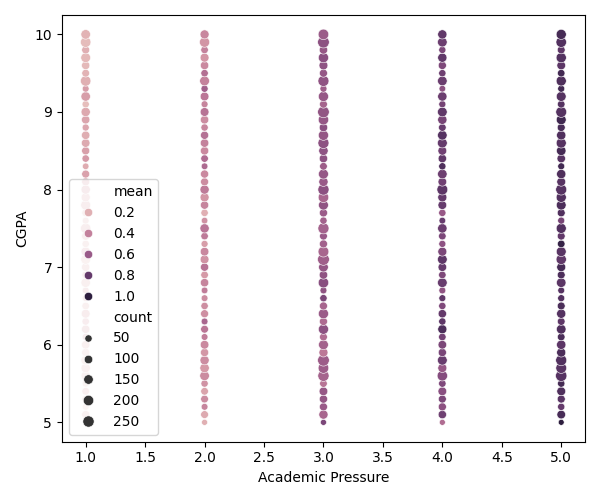

In [225]:
sc.cache_fig(
    'Academic_Pressure_CGPA',
    lambda x: sns.scatterplot(
        df_train[['Academic Pressure', 'CGPA', target]].dropna().assign(
            CGPA = lambda x: x['CGPA'].round(1)
        ).groupby(['Academic Pressure', 'CGPA'], as_index=False)[target].agg(['mean', 'count']),
        x = 'Academic Pressure', y ='CGPA', hue = 'mean', size = 'count', ax=x
    ), figsize=(6, 5)
)

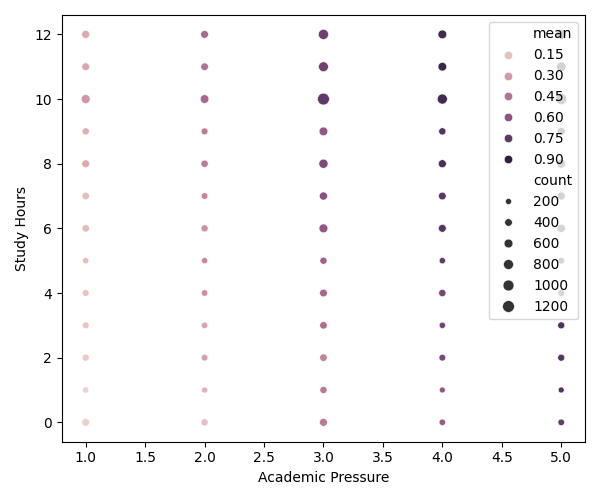

In [226]:
sc.cache_fig(
    'Academic_Pressure_Study_Hours',
    lambda x: sns.scatterplot(
        df_train[['Academic Pressure', 'Study Hours', target]].dropna().assign(
            CGPA = lambda x: x['Study Hours'].round(1)
        ).groupby(['Academic Pressure', 'Study Hours'], as_index=False)[target].agg(['mean', 'count']),
        x = 'Academic Pressure', y ='Study Hours', hue = 'mean', size = 'count', ax=x
    ), figsize=(6, 5)
)

In [227]:
df_train.loc[df_train[['Academic Pressure', 'Study Hours']].notna().all(axis=1), target].value_counts(normalize=True)

Depression
1    0.585583
0    0.414417
Name: proportion, dtype: float64

In [228]:
result = sc.cache_result(
    'lr_Interaction',
    lambda : sgml.cv(
        df_train.loc[df_train[['Academic Pressure', 'Study Hours', 'CGPA']].notna().all(axis=1)], skf, 
        {'model_params': {}, 'X_mm': ['Academic Pressure', 'Study Hours', 'CGPA']}, 
        config, lr_adapter
    )
)
np.mean(result['valid_scores'])

0.7366817544483613

## +LDA

In [229]:
hparams = {
    'model_params': {'n_estimators': 1500, 'learning_rate': 0.02, 'max_depth': 5, 'colsample_bytree': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'ohe': {'min_frequency': 50, 'drop': 'if_binary'},
    'lda': {
        'X_mm':  [
            'Academic Pressure_FZ', 'Study Hours', 'CGPA_FZ'
        ],
    },
    'validation_fraction': 0.1
}

result = sc.cache_result(
    'xgb_lda',
    lambda : sgml.cv(df_train, skf, hparams, config, xgb_adapter)
)
np.mean(result['valid_scores'])

0.9400213219616205

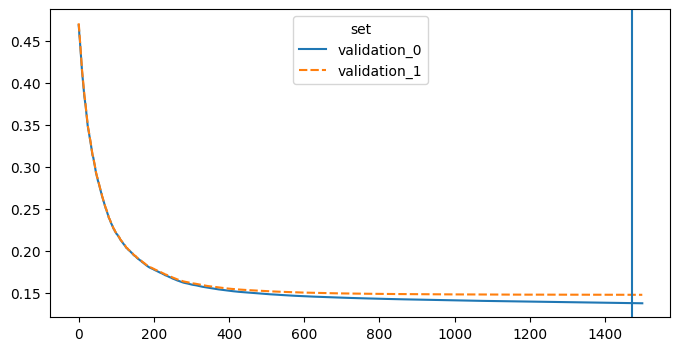

In [230]:
plt.figure(figsize=(8, 4))
valid_result = pd.concat([i['valid_result'] for i in result['model_result']], axis=1).T.groupby(level=1).mean().T
sns.lineplot(valid_result)
plt.axvline(valid_result['validation_1'].idxmin())
plt.show()

In [231]:
result = sc.cache_result(
    'xgb_lda_train',
    lambda : sgml.train(df_train, hparams, config, xgb_adapter)
)

In [232]:
def get_shap_interaction_values():
    ct = result[0]['preprocessor']
    df_sub = df_train.sample(frac=0.01, random_state=123)
    X = pd.DataFrame(ct.transform(df_sub).todense(), index=df_sub.index, columns=result[0]['variables'])
    shap_values = shap.TreeExplainer(result[0]['model']).shap_interaction_values(X)
    return shap_values, df_sub, X

shap_interaction_values, df_sub, X = sc.cache_result(
    'xgb_shap_interaction_values2', get_shap_interaction_values
)

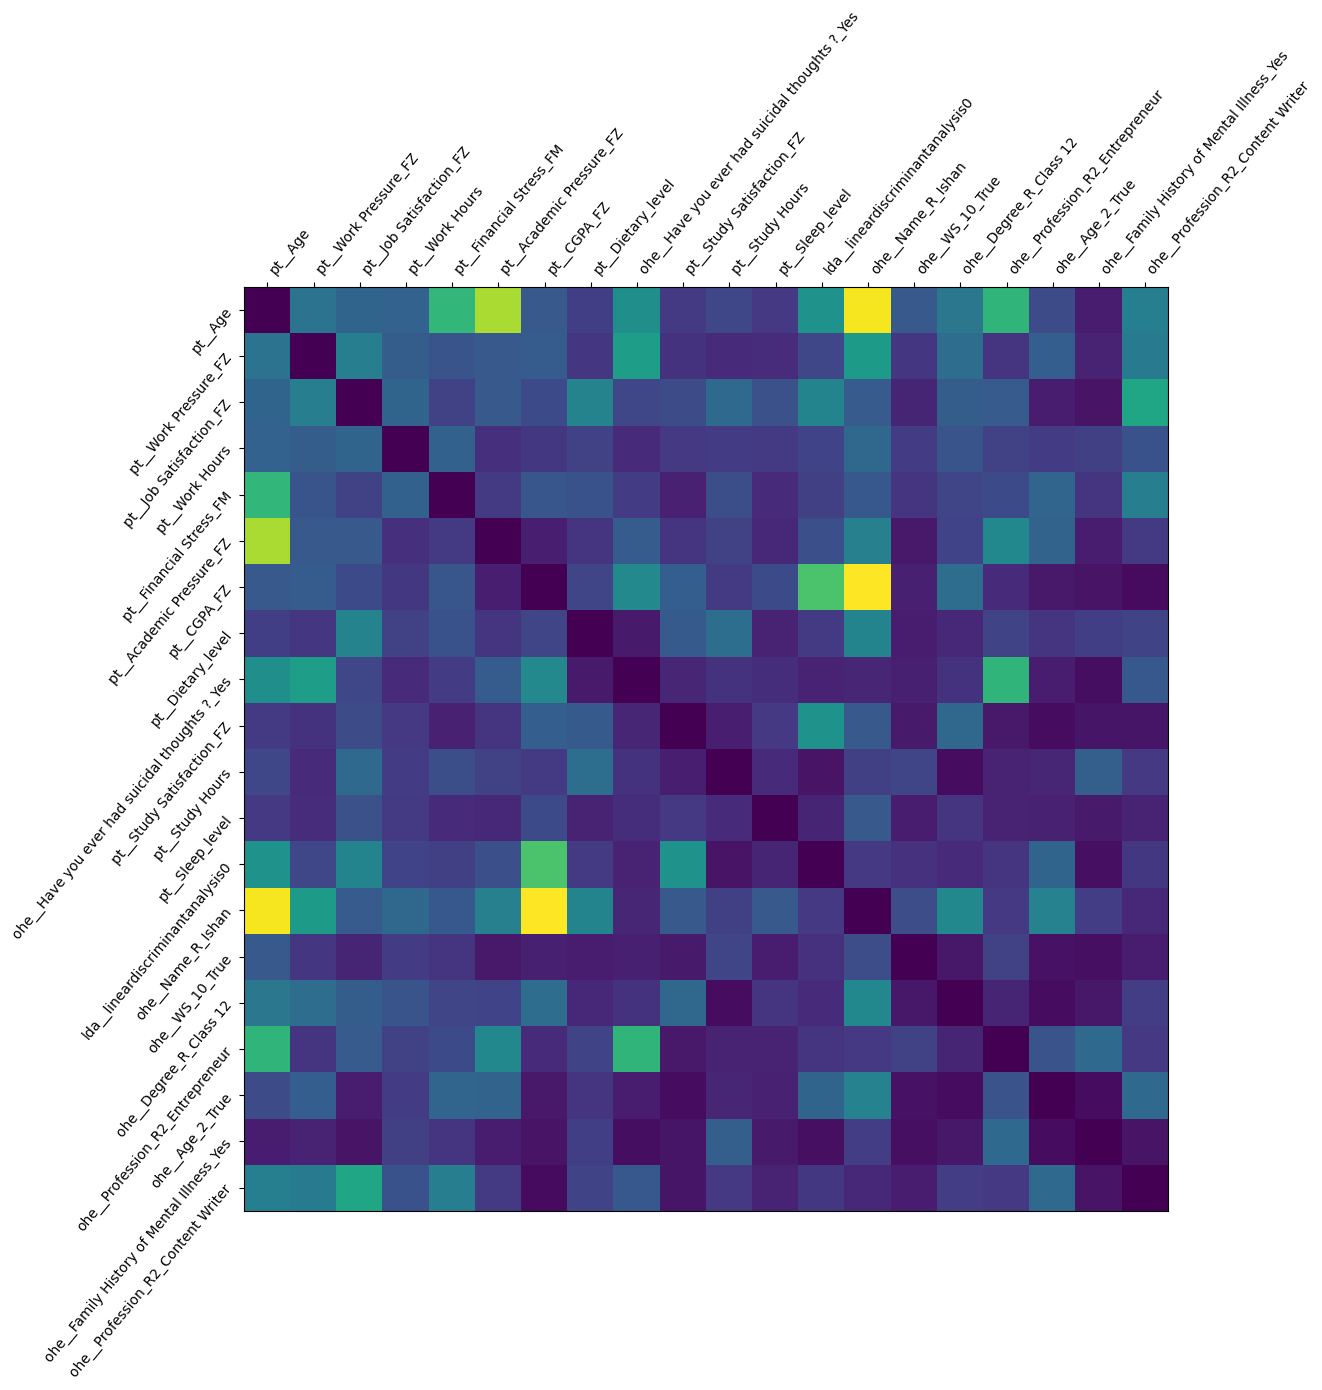

In [233]:
interaction_matrix = np.abs(shap_interaction_values).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(12, 12))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

# CB

In [234]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.05, 'max_depth': 5, 'rsm': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_cat': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'validation_fraction': 0.1
}

result = sc.cache_result(
    'simple_cb',
    lambda : sgml.cv(df_train, skf, hparams, config, cb_adapter)
)
np.mean(result['valid_scores']), np.mean(result['train_scores'])

(0.940319829424307, 0.9463148542999289)

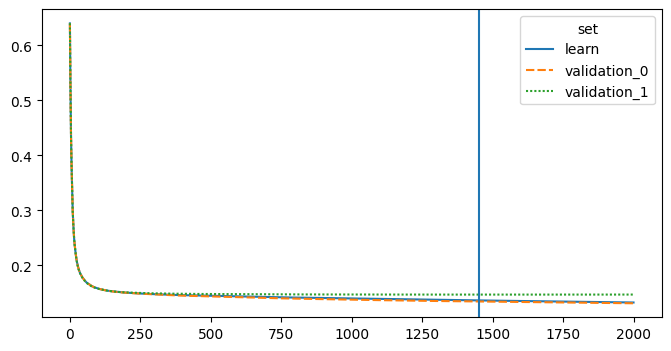

In [235]:
plt.figure(figsize=(8, 4))
valid_result = pd.concat([i['valid_result'] for i in result['model_result']], axis=1).T.groupby(level=1).mean().T
sns.lineplot(valid_result)
plt.axvline(valid_result['validation_1'].idxmin())
plt.show()

In [236]:
c, X = sc.cache_result(
    'CB_shap_train',
    lambda : sgml.train(df_train, hparams, config, cb_adapter, result_proc = sgml.m_learning_result)
)

In [237]:
explainer = sc.cache_result(
    'cb_shap_explainer', lambda : shap.TreeExplainer(c['model'])
)
def get_shap_values():
    ct = c['preprocessor']
    df_sub = df_train.sample(frac=0.05, random_state=123)
    X = pd.DataFrame(ct.transform(df_sub), index=df_sub.index, columns=c['variables'])
    shap_values = explainer.shap_values(X)
    return shap_values, df_sub, X

shap_values, df_sub, X = sc.cache_result(
    'cb_shap_values', get_shap_values
)

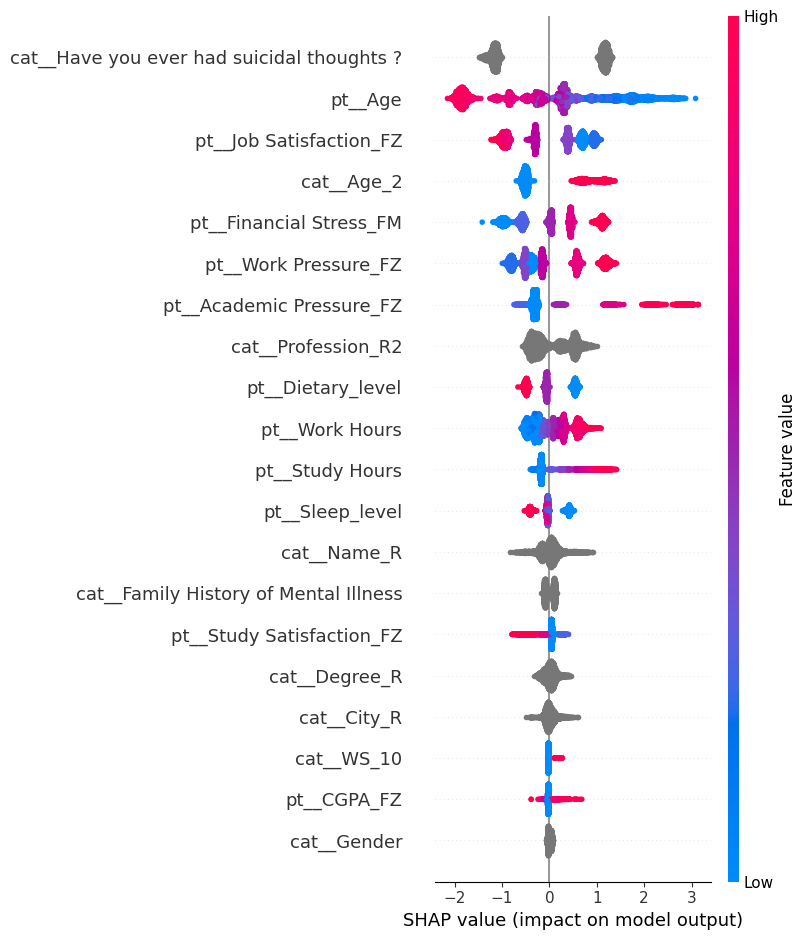

In [238]:
shap.summary_plot(shap_values, X)

In [239]:
def get_shap_interaction_values():
    ct = c['preprocessor']
    df_sub = df_train.sample(frac=0.01, random_state=123)
    X = pd.DataFrame(ct.transform(df_sub), index=df_sub.index, columns=c['variables'])
    shap_values = shap.TreeExplainer(c['model']).shap_interaction_values(X)
    return shap_values, df_sub, X

shap_interaction_values, df_sub, X = sc.cache_result(
    'cb_shap_interaction_values', get_shap_interaction_values
)

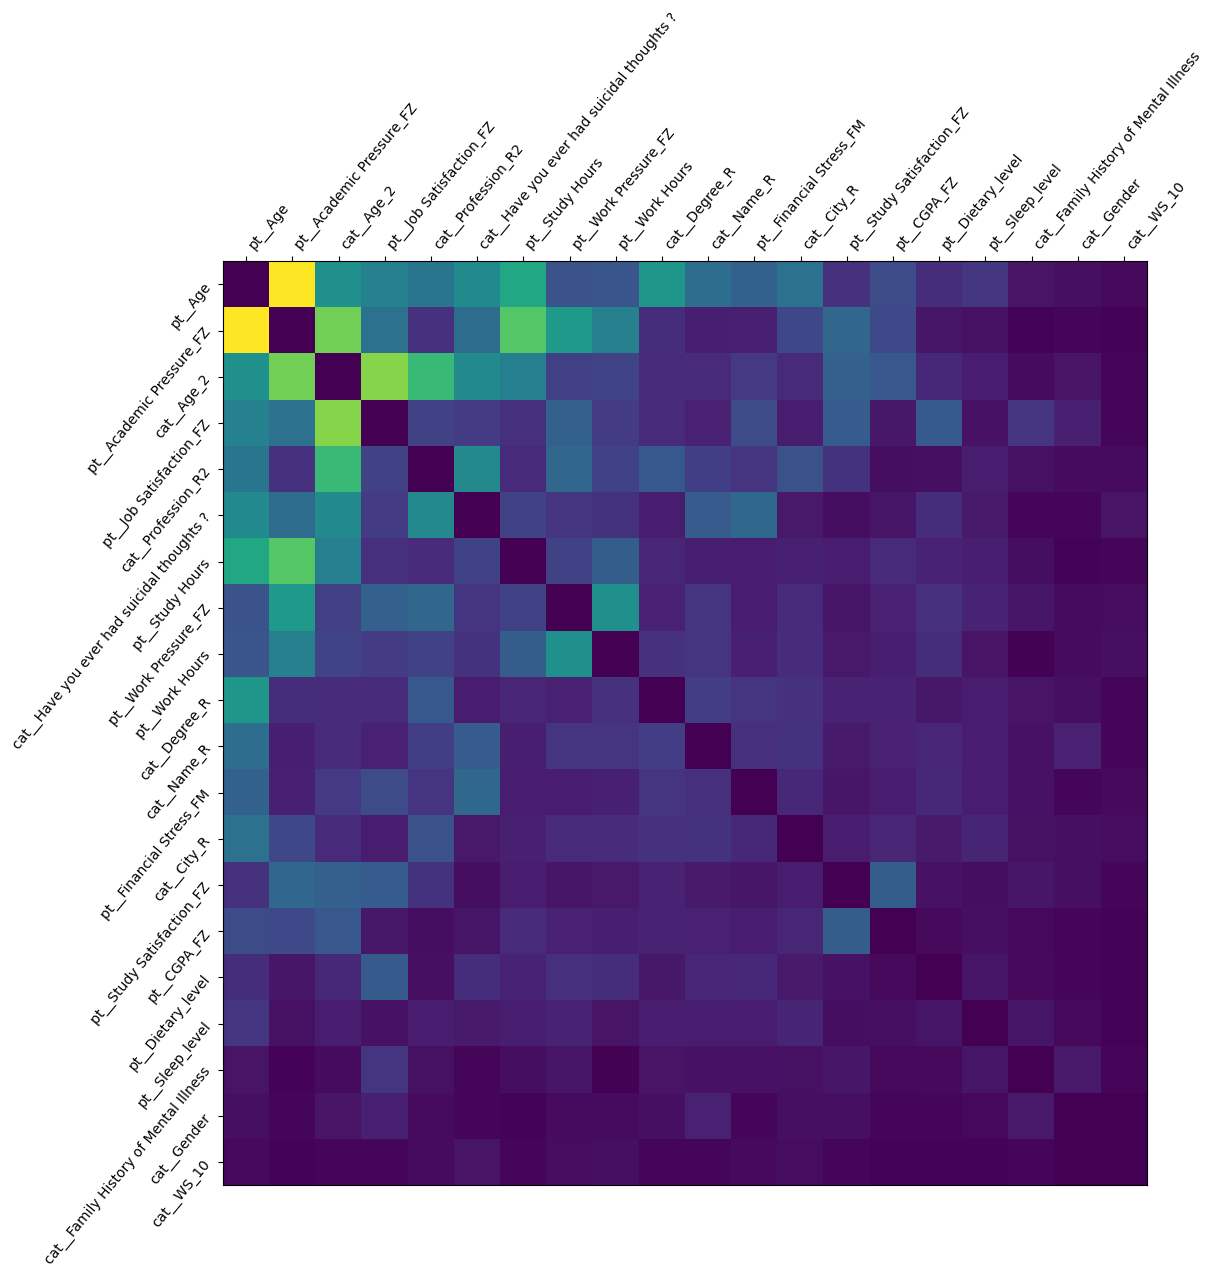

In [240]:
interaction_matrix = np.abs(shap_interaction_values).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(12, 12))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

In [241]:
hparams = {
    'model_params': {'n_estimators': 2000, 'learning_rate': 0.05, 'max_depth': 5, 'rsm': 0.25, 'subsample': 0.25},
    'X_num':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_cat': ['Name_R', 'Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Profession_R2', 'Age_2', 'Gender'],
    'lda': {
        'X_mm':  [
            'Academic Pressure_FZ', 'Study Hours', 'CGPA_FZ'
        ],
    },
    'validation_fraction': 0.1
}

result = sc.cache_result(
    'cb_lda',
    lambda : sgml.cv(df_train, skf, hparams, config, cb_adapter)
)
np.mean(result['valid_scores']), np.mean(result['train_scores'])

(0.9400568585643212, 0.9459630419331913)

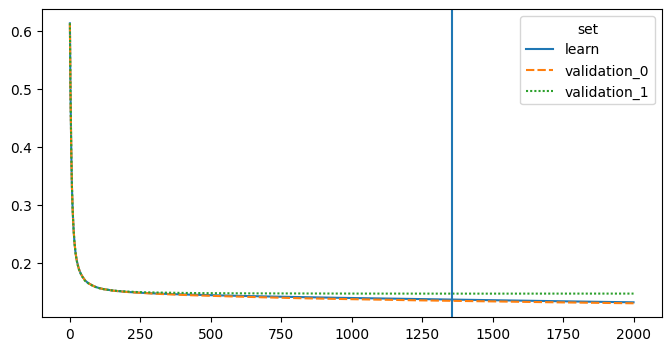

In [242]:
plt.figure(figsize=(8, 4))
valid_result = pd.concat([i['valid_result'] for i in result['model_result']], axis=1).T.groupby(level=1).mean().T
sns.lineplot(valid_result)
plt.axvline(valid_result['validation_1'].idxmin())
plt.show()

In [243]:
c, X = sc.cache_result(
    'CB_shap_train2',
    lambda : sgml.train(df_train, hparams, config, cb_adapter, result_proc = sgml.m_learning_result)
)

In [244]:
explainer = sc.cache_result(
    'cb_shap_explainer2', lambda : shap.TreeExplainer(c['model'])
)
def get_shap_values():
    ct = c['preprocessor']
    df_sub = df_train.sample(frac=0.05, random_state=123)
    X = pd.DataFrame(ct.transform(df_sub), index=df_sub.index, columns=c['variables'])
    shap_values = explainer.shap_values(X)
    return shap_values, df_sub, X

shap_values, df_sub, X = sc.cache_result(
    'cb_shap_values2', get_shap_values
)

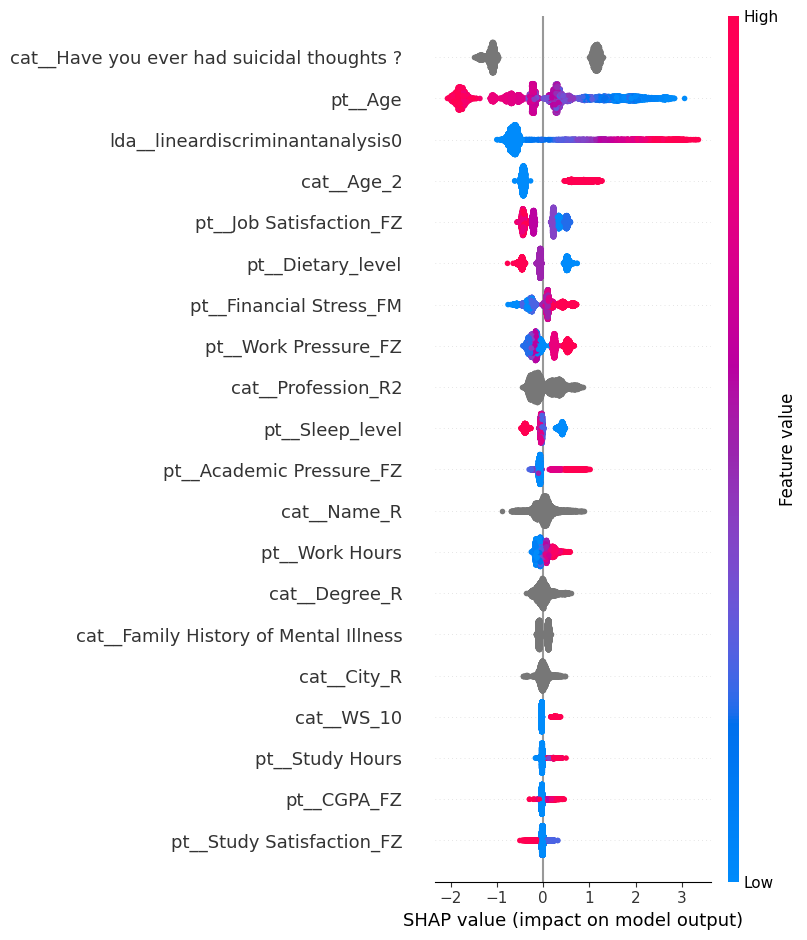

In [245]:
shap.summary_plot(shap_values, X)

In [246]:
def get_shap_interaction_values():
    ct = c['preprocessor']
    df_sub = df_train.sample(frac=0.01, random_state=123)
    X = pd.DataFrame(ct.transform(df_sub), index=df_sub.index, columns=c['variables'])
    shap_values = shap.TreeExplainer(c['model']).shap_interaction_values(X)
    return shap_values, df_sub, X

shap_interaction_values, df_sub, X = sc.cache_result(
    'cb_shap_interaction_values2', get_shap_interaction_values
)

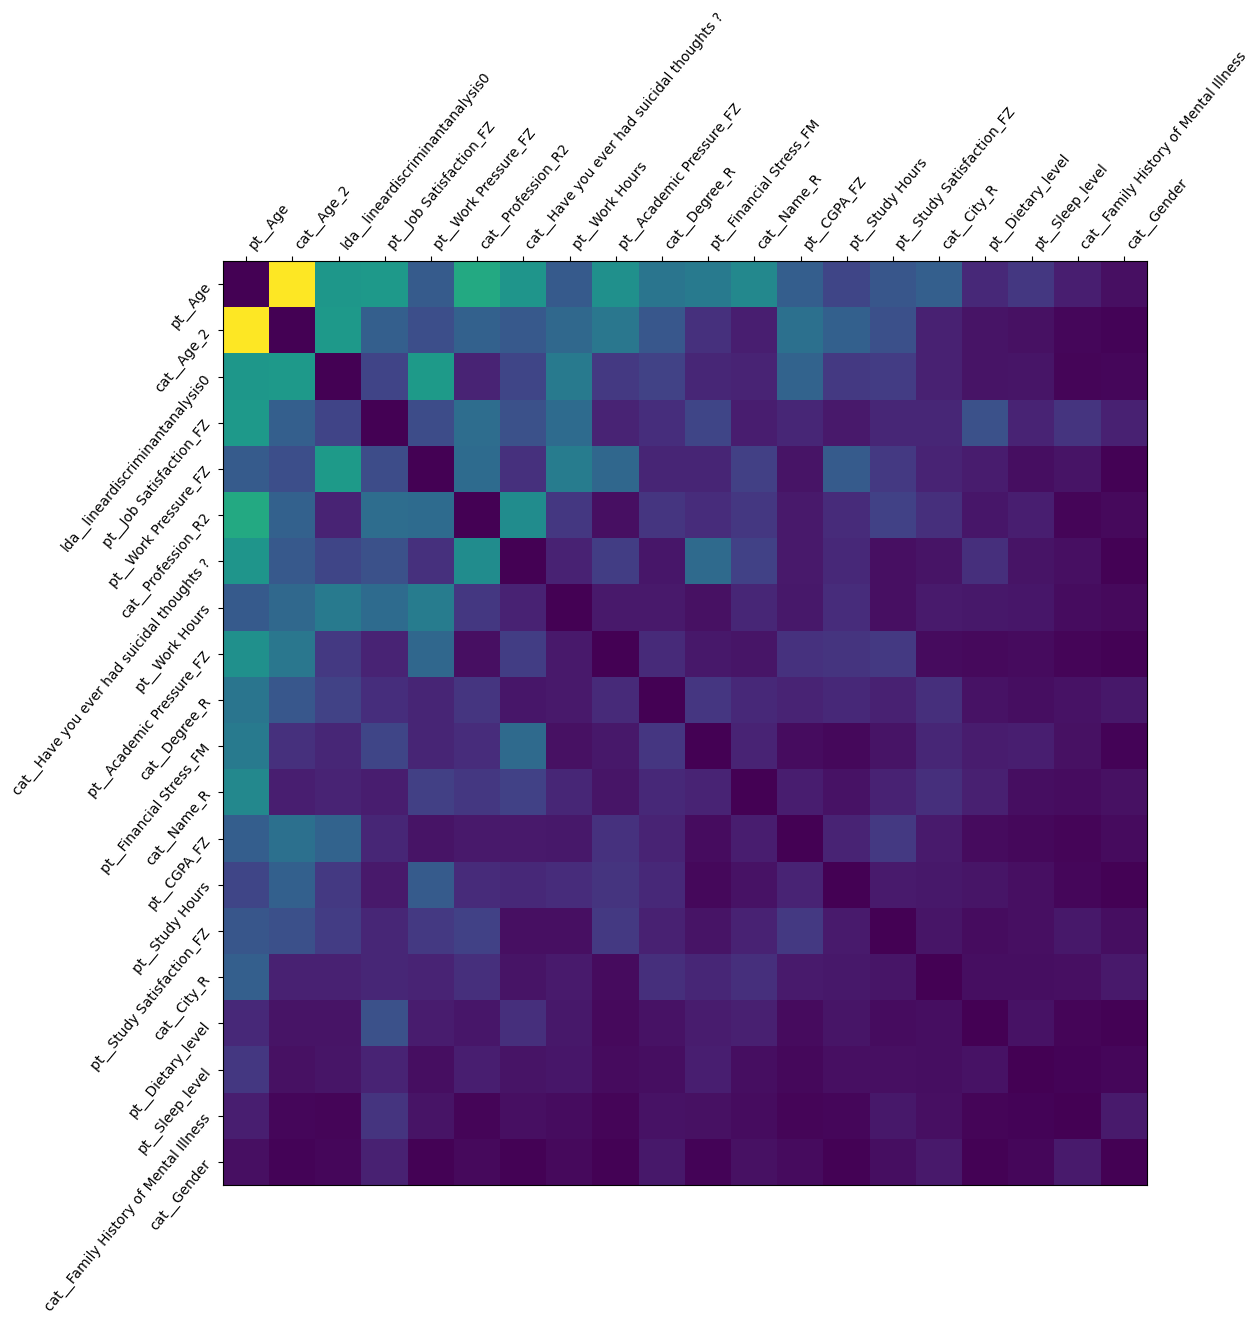

In [247]:
interaction_matrix = np.abs(shap_interaction_values).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(12, 12))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

# NN

In [248]:
from sklearn.neural_network import MLPClassifier
mlp_adapter = sgml.SklearnAdapter(MLPClassifier)

In [249]:
hparams = {
    'model_params': {'hidden_layer_sizes': [8]},
    'X_mm':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Degree_R', 'City_R', 'Name_R', 'Profession_R2', 'Age_2'],
    'ohe': {'drop': 'first', 'min_frequency': 50}
}

result = sc.cache_result(
    'simple_mlp',
    lambda : sgml.cv(df_train, ss, hparams, config, mlp_adapter)
)
np.mean(result['valid_scores']), np.mean(result['train_scores'])

(0.9360341151385928, 0.9428837953091684)

In [250]:
import sgnn
nn_adapter = sgnn.NNAdapter(model=sgnn.NNClassifier)

In [251]:
def nn_cat_param(df, name, size):
    return name, len(df[name].cat.categories), size

X_cat = ['Name_R', 'City_R', 'Profession_R2', 'Degree_R']
X_num = ['CGPA_FZ', 'Work Hours', 'Study Hours', 'Work Pressure_FZ', 'Academic Pressure_FZ', 
         'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Age', 'Financial Stress_FM', 'Sleep_level', 'Dietary_level']
X_nn_emb = [
    ('Name_R', 3), ('City_R', 2), ('Profession_R2', 2), ('Degree_R', 2)
]

nn_params = {
    'embedding':[(1, c, es, 0, 0) for _, c, es in [nn_cat_param(df_train, v, n) for v, n in X_nn_emb]], 
    'config':  [
        {'unit': 16, 'activation': 'relu', 'batch_norm': False},
#        {'unit': 4, 'activation': 'relu', 'batch_norm': False},
    ]
}

hparams = {
    'model_params': {
        'model_params': nn_params,
        'epochs': 50,
        'optimizer': ('Adam', {'learning_rate': 0.001}),
        'batch_size': 1024, 'shuffle_size': 102400,
        'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None
    }, 
    'X_cat': X_cat,
    'X_std':  [
        'Age', 'Academic Pressure_FZ', 'Financial Stress_FM', 'Work Pressure_FZ', 'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Work Hours', 
        'Study Hours', 'CGPA_FZ', 'Dietary_level', 'Sleep_level'
    ],
    'X_ohe': ['Have you ever had suicidal thoughts ?', 'WS_10', 'Family History of Mental Illness', 'Age_2'],
    'ohe': {'drop': 'first', 'min_frequency': 50, 'sparse_output': False},
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'nn1',
    lambda : sgml.cv(df_train, skf, hparams, config, nn_adapter)
)

In [252]:
np.mean(result['valid_scores'])

0.9386993603411515

# 변수 정리

In [265]:
df_var.query('src != "org"').sort_values('src')

,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,Description,src,processor
Profession_R,None,None,0.0,140700.0,38.0,None,None,None,None,None,Categorical,Profession에서 train과 test에서 빈도가 10 미만은 Noise 처리...,cat_proc,<function get_prof_proc.<locals>.<lambda> at 0...
City_R,None,None,0.0,140700.0,31.0,None,None,None,None,None,Categorical,City에서 train과 test에서 빈도가 10 미만은 Noise 처리합니다.,cat_proc,<function get_city_proc.<locals>.<lambda> at 0...
Degree_R,None,None,0.0,140700.0,28.0,None,None,None,None,None,Categorical,"Degree에서 train과 test에서 최대한 유사 빈도의 카테고리로 치환하고, ...",cat_proc,<function get_degree_proc.<locals>.<lambda> at...
Dietary Habits_R,None,None,0.0,140700.0,4.0,None,None,None,None,None,Categorical,Dietary Habits에서 train과 test에서 최대한 유사 빈도의 카테고리...,cat_proc,<function get_dietary_proc.<locals>.<lambda> a...
Name_R,None,None,0.0,140700.0,218.0,None,None,None,None,None,Categorical,Name에서 train과 test에서 빈도가 20 미만은 Noise 처리합니다.,cat_proc,<function get_name_proc.<locals>.<lambda> at 0...
Sleep Duration_R,None,None,0.0,140700.0,5.0,None,None,None,None,None,Categorical,Sleep Duration에서 train과 test에서 최대한 유사 빈도의 카테고리...,cat_proc,<function get_sleep_proc.<locals>.<lambda> at ...
Age_18_Unknown,False,True,0.0,140700.0,2.0,True,True,True,True,None,Bool,18세 이고 직업이 Unknown 인지 여부를 나타냅니다.,combine_cat,<function <lambda> at 0x7f421e72aac0>
Age_Suicidal,None,None,0.0,140700.0,4.0,None,None,None,None,None,Categorical,Age 2와 Have you ever had suicidal thoughts ?을 ...,combine_cat,<function <lambda> at 0x7f421e729b20>
WS_Degree,None,None,0.0,140700.0,56.0,None,None,None,None,None,Categorical,Working Professional or Student와 Degree_R을 결합합니다.,combine_cat,<function <lambda> at 0x7f421e72ad40>
Prof_Degree,None,None,0.0,140700.0,602.0,None,None,None,None,None,Categorical,Profession_R2과 Degree_R을 결합합니다.,combine_cat,<function <lambda> at 0x7f421e72af20>


In [266]:
df_test, nq = dproc.apply_pd_procs(df_test, df_var.loc[df_var['processor'].notna(), 'processor'])
df_test

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,...,Dietary_level,Sleep_level,Dietary Habits_R,Degree_R,City_R,CGPA_FZ,Age_Suicidal,Age_2,Age_18_Unknown,Academic Pressure_FZ
id,,,,,,,,,,,,,,,,,,,,,
140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,...,0,-2,Moderate,LLB,Visakhapatnam,0.00,False_No,False,False,0
140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,...,0,-2,Moderate,B.Ed,Kolkata,0.00,False_No,False,False,0
140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,...,0,1,Moderate,B.Arch,Jaipur,0.00,False_Yes,False,False,0
140703,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,...,0,2,Moderate,BSc,Rajkot,6.84,True_Yes,True,False,5
140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,...,0,1,Moderate,BCA,Kalyan,0.00,False_Yes,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234495,Zoya,Female,49.0,Jaipur,Working Professional,Pilot,NaN,3.0,NaN,NaN,...,0,-2,Moderate,BSc,Jaipur,0.00,False_Yes,False,False,0
234496,Shlok,Male,29.0,Ahmedabad,Working Professional,Pilot,NaN,5.0,NaN,NaN,...,0,1,Moderate,BE,Ahmedabad,0.00,True_Yes,True,False,0
234497,Rishi,Male,24.0,Visakhapatnam,Student,NaN,1.0,NaN,7.51,4.0,...,0,1,Moderate,B.Tech,Visakhapatnam,7.51,True_No,True,False,1


In [267]:
df_train.loc[:, df_train.columns.isin(df_var.index)].to_feather(os.path.join('data', 'train_w.feather'))

In [268]:
with open(os.path.join('data', 'var_w.dill'), 'wb') as f:
    dill.dump(df_var, f)

In [299]:
df_train.loc[
    (df_train['Profession_R2'] == 'Student') & df_train[['Academic Pressure', 'CGPA', 'Study Satisfaction']].isna().any(axis=1),  :'Depression'
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
17549,Tanya,Female,20.0,Patna,Student,NaN,NaN,NaN,5.55,NaN,NaN,5-6 hours,Moderate,Class 12,No,0.0,3.0,Yes,0
18344,Shivam,Male,30.0,Faridabad,Student,NaN,5.0,NaN,5.74,NaN,NaN,Less than 5 hours,Unhealthy,MCA,Yes,0.0,3.0,Yes,1
60348,Nishant,Male,29.0,Agra,Working Professional,NaN,NaN,NaN,9.72,2.0,NaN,5-6 hours,Moderate,B.Ed,No,7.0,2.0,Yes,0
102714,Aahana,Female,18.0,Bhopal,Student,NaN,4.0,NaN,5.88,NaN,NaN,Less than 5 hours,Moderate,Class 12,Yes,5.0,1.0,No,1
122983,Saanvi,Female,30.0,Ghaziabad,Student,NaN,NaN,NaN,5.47,2.0,NaN,Less than 5 hours,Unhealthy,B.Com,Yes,5.0,1.0,No,0
137013,Vikram,Male,36.0,Varanasi,Student,NaN,NaN,NaN,8.54,3.0,NaN,More than 8 hours,Moderate,Class 12,Yes,8.0,5.0,Yes,1


In [301]:
df_train.loc[
    (df_train['Profession_R2'] != 'Student') & df_train[['Work Pressure', 'Job Satisfaction']].isna().any(axis=1),  :'Depression'
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
15846,Shrey,Male,53.0,Vasai-Virar,Working Professional,NaN,NaN,NaN,NaN,NaN,5.0,More than 8 hours,Unhealthy,Class 12,No,12.0,1.0,No,0
25647,Ishwar,Male,57.0,Kalyan,Working Professional,NaN,NaN,1.0,NaN,NaN,NaN,Less than 5 hours,Unhealthy,Class 12,No,4.0,1.0,No,0
34694,Kriti,Female,46.0,Meerut,Working Professional,NaN,NaN,NaN,NaN,NaN,NaN,5-6 hours,Moderate,Class 12,Yes,12.0,3.0,No,0
35612,Siddhesh,Male,27.0,Vadodara,Working Professional,NaN,NaN,NaN,NaN,NaN,NaN,Less than 5 hours,Unhealthy,B.Pharm,No,11.0,3.0,No,1
52199,Manan,Male,50.0,Agra,Working Professional,NaN,NaN,4.0,NaN,NaN,NaN,5-6 hours,Unhealthy,Class 12,No,1.0,3.0,Yes,0
52737,Aarav,Male,28.0,Vadodara,Student,NaN,3.0,NaN,NaN,4.0,NaN,Less than 5 hours,Healthy,BBA,No,12.0,2.0,No,0
55222,Trisha,Female,21.0,Varanasi,Working Professional,NaN,NaN,5.0,NaN,NaN,NaN,7-8 hours,Moderate,B.Arch,No,11.0,2.0,Yes,0
57196,Manvi,Female,20.0,Visakhapatnam,Working Professional,NaN,NaN,NaN,NaN,NaN,NaN,Less than 5 hours,Moderate,Class 12,No,0.0,4.0,Yes,1
58062,Ishita,Female,32.0,Vadodara,Student,NaN,5.0,NaN,NaN,NaN,NaN,Less than 5 hours,Unhealthy,Class 12,Yes,11.0,5.0,No,1


In [296]:
df_train.loc[
    (df_train['Profession_R2'] == 'Student') & df_train[['Work Pressure', 'Job Satisfaction']].notna().any(axis=1),  :'Depression'
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
1428,Rishi,Male,29.0,Srinagar,Student,NaN,3.0,NaN,9.63,3.0,3.0,7-8 hours,Moderate,M.Pharm,No,8.0,5.0,No,0
116703,Neil,Male,25.0,Bangalore,Student,NaN,4.0,NaN,9.44,5.0,2.0,Less than 5 hours,Unhealthy,PhD,Yes,4.0,1.0,No,1


In [297]:
df_train.loc[
    (df_train['Profession_R2'] != 'Student') & df_train[['Academic Pressure', 'Study Satisfaction']].notna().any(axis=1),  :'Depression'
]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
52737,Aarav,Male,28.0,Vadodara,Student,NaN,3.0,NaN,NaN,4.0,NaN,Less than 5 hours,Healthy,BBA,No,12.0,2.0,No,0
58062,Ishita,Female,32.0,Vadodara,Student,NaN,5.0,NaN,NaN,NaN,NaN,Less than 5 hours,Unhealthy,Class 12,Yes,11.0,5.0,No,1
110097,Abhinav,Male,34.0,Pune,Student,NaN,1.0,NaN,NaN,5.0,NaN,Less than 5 hours,Unhealthy,M.Ed,Yes,10.0,3.0,Yes,0
